# Disentangled representation of intention in macaque prefrontal cortex

Herein we train a model to yield a low-dimensional latent vector that encodes only the intended saccade target, and is disentangled from another low-dimensional timeseries that encodes simple dynamics related to target-agnostic task events.

## Resources

[Notes on beta-VAE in general](https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_04_betaVAE_TFP.ipynb).

[Disentangled sequential autoencoders paper, by Li and Mandt, ICML 2018](https://arxiv.org/pdf/1803.02991.pdf), with an implementation in [TF Probability by google](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py) and in [pytorch by yatindandi/Disentangled-Sequential-Autoencoder](https://github.com/yatindandi/Disentangled-Sequential-Autoencoder).

Further extensions of this concept can be found [Swapping Autoencoder for Deep Image Manipulation by Park et al., 2020](https://arxiv.org/pdf/2007.00653.pdf) with [pytorch implementation](https://github.com/rosinality/swapping-autoencoder-pytorch).
* discriminator for real vs fake when keeping dynamic latent but swapping static latent from another trial.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys


try:
    # See if we are running on google.colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
            
    if Path.cwd().stem == 'MonkeyPFCSaccadeStudies':
        os.chdir(Path.cwd().parent)
    if not (Path.cwd() / 'MonkeyPFCSaccadeStudies').is_dir():
        !git clone --single-branch --recursive https://github.com/SachsLab/MonkeyPFCSaccadeStudies.git
        sys.path.append(str(Path.cwd() / 'MonkeyPFCSaccadeStudies'))
    os.chdir('MonkeyPFCSaccadeStudies')
        
    !pip install git+https://github.com/SachsLab/indl.git
    !pip install -q kaggle
    !pip install --upgrade tensorflow-probability
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
# Additional imports
from functools import partial
import math
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from indl.display import turbo_cmap
if True:
    plt.style.use('dark_background')
else:
    plt.style.use('seaborn-poster')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 1,
    'lines.markersize': 5,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 18,
    'figure.figsize': (8, 6.4)
})


## Download Data (if necessary)

In [5]:
if IN_COLAB:
    data_path = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    data_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Get Data

We will use a custom function `load_macaque_pfc` to load the data into memory.

There are 4 different strings to be passed to the import `x_chunk` argument:
* 'analogsignals' - if present. Returns 1 kHz LFPs
* 'gaze'          - Returns 2-channel gaze data.
* 'spikerates'    - Returns smoothed spikerates
* 'spiketrains'

The `y_type` argument can be
* 'pair and choice' - returns Y as np.array of (target_pair, choice_within_pair)
* 'encoded input' - returns Y as np.array of shape (n_samples, 10) (explained below)
* 'replace with column name' - returns Y as a vector of per-trial values. e.g., 'sacClass'

The actual data we load depends on the particular analysis below.

In [6]:
from misc.misc import sess_infos, load_macaque_pfc

load_kwargs = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': False,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.35),  # np.inf),
    'verbose': True,
    'y_type': 'sacClass',
    'samples_last': False,
    'resample_X': 10
}

### Load Data

In [7]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")

# Different x_chunk values: 'analogsignals' (i.e. LFPs), 'spikerates', 'spiketrains', 'gaze'
# Rates...
#X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
# Set baseline to 0. Makes reconstruction with relu easier.
#X_rates = X_rates - np.min(np.min(X_rates, axis=0, keepdims=True), axis=1, keepdims=True)
#X_rates = X_rates.astype(np.float32)

X_spikes, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spiketrains',
                                              **load_kwargs)
X_spikes = X_spikes * load_kwargs['resample_X']  # spks/msec -> spks/bin
X_spikes = X_spikes.astype(np.float32)
Y_class = tf.keras.utils.to_categorical(Y_class, num_classes=8)


Importing session sra3_1_j_050_00+
Found 663 trials, 161 timestamps(-0.2455 to 1.35 at 100.0 Hz), 36 channels
Returning Y as sacClass with shape (663, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


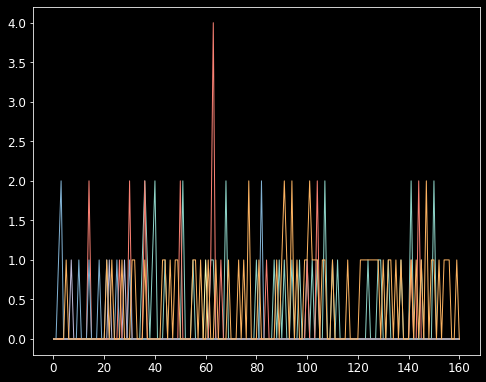

In [8]:
plt.plot(X_spikes[1, :, ::6])

## Model

### Hyperparameters

In [9]:
USE_READIN = False
N_HIDDEN_STATIC = 128                # Number of RNN cells in static encoder network
LATENT_SIZE_STATIC = 64              # Size of static latent vector f | g_0
STATIC_LATENT_OFF_DIAG = False
DYNAMIC_GRAPH = 'full'               # 'none', 'factorized', 'full', 'controller'
N_HIDDEN_DYNAMIC = 12                # Number of RNN cells in dynamic encoder
LATENT_SIZE_DYNAMIC = 2              # Size of dynamic latent vector z_t | u_t
DYNAMIC_LATENT_OFF_DIAG = False
N_HIDDEN_GEN = 256                   # Number of RNN cells in generator
N_FACTORS = 36                       # Number of latent factors ?? | f_t
# NUM_RECONSTRUCTION_SAMPLES = 1
BATCH_SIZE = 16
NUM_SAMPLES = 4
RANDOM_SEED = 1337
N_EPOCHS = 150
MAX_GRAD_NORM = 200.0
DROPOUT_RATE = 0.025
L2_REG = 2e-5

### Helper Imports

Much of our model will be created by creating model blocks comprising multiple layers/transformations. Here we import some helper functions and classes for simplifying model creation.

The AutoShape classes are necessary because otherwise a block that is a tf.keras.Model subclass does not report its shape properly.

In [10]:
from indl.model.tfp import scale_shift
from indl.model import parts
from indl.model.autoshape_mixin import AutoShapeMixin


class BidirectionalAutoShape(AutoShapeMixin, tfkl.Bidirectional):
    pass
class GRUAutoShape(AutoShapeMixin, tfkl.GRU):
    pass
class DenseAutoShape(AutoShapeMixin, tfkl.Dense):
    pass
class DistLambdaAutoShape(AutoShapeMixin, tfpl.DistributionLambda):
    pass
class GRUCellAutoShape(AutoShapeMixin, tfkl.GRUCell):
    pass
class DropoutAutoShape(AutoShapeMixin, tfkl.Dropout):
    pass
class WeightNormAutoShape(AutoShapeMixin, tfa.layers.WeightNormalization):
    pass

In [11]:
# from indl.data.augmentations import random_slice
ds = tf.data.Dataset.from_tensor_slices((X_spikes, Y_class))
# Any augmentations. e.g., random slicing.
# p_random_slice = partial(random_slice, max_offset=3, axis=0)
# ds = ds.map(p_random_slice)
ds = ds.shuffle(X_spikes.shape[0] + 1)
ds = ds.batch(BATCH_SIZE, drop_remainder=True)
print(ds.element_spec)

input_shape = ds.element_spec[0].shape.as_list()
input_shape[0] = None  # Batch dim
input_shape = tuple(input_shape)
n_times, n_sensors = input_shape[-2:]

(TensorSpec(shape=(16, 161, 36), dtype=tf.float32, name=None), TensorSpec(shape=(16, 8), dtype=tf.float32, name=None))


### Read-In Feature Extraction (Optional)

This optional part of the model does some mild feature extraction on the input data. The intention is to transform the data into a common dimensionality and space.

Input shape: `(batch, samples, channels)`

Output shape: `(batch, samples//pooling, n_kernels*depth_multiplier)`

In [ ]:
def ReadIn(input_shape, n_kernels=6, kern_length=25, depth_multiplier=2, activation=tf.nn.leaky_relu, pooling=5, dropout_rate=0.25):
    n_times, n_sensors = input_shape[-2:]
    return tf.keras.Sequential([
        tfkl.Input(shape=input_shape[-2:]),
        tfkl.Reshape(input_shape[-2:] + (1,)),
        tfkl.Conv2D(n_kernels, (kern_length, 1), padding='same', use_bias=False, name="temporal_filter"),
        #     tfkl.BatchNormalization(name="temporal_filter_bnorm"),
        tfkl.DepthwiseConv2D((1, n_sensors), padding='valid',
                             depth_multiplier=depth_multiplier, use_bias=False, name="spatial_filter"),
        #     tfkl.BatchNormalization(name="spatial_filter_bnorm"),
        tfkl.Activation(activation),
        tfkl.AveragePooling2D((pooling, 1), name="temporal_smoothing"),
        #     tfkl.Dropout(dropout_rate),
        tfkl.Reshape((n_times // pooling, n_kernels * depth_multiplier))],
        name="read_in")

K.clear_session()
read_in = ReadIn(input_shape)
read_in.summary()

# temp_input = tf.random.uniform(ds.element_spec[0].shape)
# tmp = read_in(temp_input)
# print(tmp)

### Encoder
Posterior distributions `q` of latents $f$ (static) and $z_t$ (dynamic) are conditioned on input sequence $x_t$.

Latent postierior, Static only:
$$q(f | x_{1:T})$$

Latent posterior, Static and Dynamic Factorized:
$$q(z_{1:T}, f | x_{1:T}) = q(f | x_{1:T}) \prod_{t=1}^T q(z_t | x_t)$$

Latent posterior, Static and Dynamic Full:
$$q(z_{1:T}, f | x_{1:T}) = q(f | x_{1:T}) q(z_{1:T} | f, x_{1:T})$$
Note that _q(z)_ depends on _f_

#### Static Encoder

Transform full sequence of "features" (`inputs` or `ReadIn(inputs)`) through (1) bidirectional LSTM then (2) affine to yield parameters of static latent posterior distribution:
$$q(f | x_{1:T})$$
This distribution is a multivariate normal, optionally with off-diagonal elements allowed.

Model loss will include the KL divergence between the static latent posterior and a prior; the prior is a learnable multivariate normal diagonal. The prior is initialized with a mean of 0 and a stddev of 1 but these are trainable by default.

See [this notebook](https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_04_betaVAE_TFP.ipynb) under the section "**Define the latent prior**" for a discussion on the merits of allowing off-diagonal elements on the prior.

In [12]:
from indl.model.tfp import LearnableMultivariateNormalDiag  # For prior
from indl.model.tfp import make_mvn_prior  # , make_mvn_dist_fn


scale_shift = np.log(np.exp(1) - 1).astype(np.float32)


class StaticEncoder(AutoShapeMixin, tf.keras.Model):
    def __init__(self, units=64, latent_size=32, dropout_rate=DROPOUT_RATE, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.latent_size = latent_size
        
        # Model layers parameterizations do not depend on input shape so we can initialize
        #  them here instead of .build()
        self.dropout = DropoutAutoShape(dropout_rate)
        # input --> bidirectional GRU --> loc & scale --> MVN distribution
        self.static_latent_rnn = BidirectionalAutoShape(
            GRUAutoShape(self.units, return_sequences=False),
            merge_mode="concat", name="static_latent_rnn")
        self.static_latent_loc = DenseAutoShape(self.latent_size, name="static_latent_loc")
        if STATIC_LATENT_OFF_DIAG:
            self.static_latent_scale = DenseAutoShape(
                tfpl.MultivariateNormalTriL.params_size(self.latent_size) - self.latent_size,
                name="static_latent_scale")
            self.shift_scale = tfp.bijectors.FillScaleTriL()
            self.static_latent_posterior = DistLambdaAutoShape(
                make_distribution_fn=lambda t: tfd.MultivariateNormalTriL(loc=t[0], scale_tril=t[1]),
#                 convert_to_tensor_fn=lambda s: s.sample(n_samples),
                name="static_latent_posterior")
        else:
            self.static_latent_scale = DenseAutoShape(
                tfpl.IndependentNormal.params_size(self.latent_size) - self.latent_size,
                name="static_latent_scale")
            self.shift_scale = lambda x: tf.math.softplus(x + scale_shift) + 1e-5
            self.static_latent_posterior = DistLambdaAutoShape(
                make_distribution_fn=lambda t: tfd.MultivariateNormalDiag(loc=t[0], scale_diag=t[1]),
#                 convert_to_tensor_fn=lambda s: s.sample(n_samples),
                name="static_latent_posterior")
            
        # Define the static prior
        #if STATIC_PRIOR_OFF_DIAG: self.prior = make_mvn_prior(latent_size, trainable=False)
        # TODO: prior variance constant kappa=0.1
        self.static_prior_factory = LearnableMultivariateNormalDiag(self.latent_size)
        self.static_prior_factory.build(input_shape=(0,))
        
    def call(self, inputs, training=None):
        _inputs = self.dropout(inputs, training=training)
        _hidden_state = self.static_latent_rnn(inputs)
        _loc = self.static_latent_loc(_hidden_state)
        _scale = self.static_latent_scale(_loc)
        _shifted_scale = self.shift_scale(_scale)
        _q_f = self.static_latent_posterior([_loc, _shifted_scale])
        return _q_f   
    
K.clear_session()

static_encoder = StaticEncoder(units=N_HIDDEN_STATIC, latent_size=LATENT_SIZE_STATIC)

features_shape = (BATCH_SIZE,) + (read_in.output_shape[1:] if USE_READIN else input_shape[1:])
print(f"Input shape: {(None,) + features_shape[1:]}")
dummy_latent = static_encoder(tf.random.uniform(features_shape))
static_encoder.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Input shape: (None, 161, 36)
Model: "static_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_auto_shape (DropoutA (None, 161, 36)           0         
_________________________________________________________________
static_latent_rnn (Bidirecti (None, 256)               127488    
_________________________________________________________________
static_latent_loc (DenseAuto (None, 64)                16448     
_________________________________________________________________
static_latent_scale (DenseAu (None, 64)                4160      
_________________________________________________________________
static_latent_posterior (Dis (None, 64)                0         
_________________________________________________________________
learnable_multivariate_norma multiple                  128       
To

#### Dynamic Encoder ($z_t$)

Input features are transformed through (1) a bidirectional LSTM (`return_sequences=True`), (2) then RNN, and (3) a pair of affines to yield the parameters of the dynamic posterior latent distribution:

$q(z_t | x_{1:T})$

This is a multivariate normal distribution **at each timestep**, conditioned on features from $x_t$ **and optionally concatenated with static latent factors $f$** in the full not-factorized model.

##### Compared to LFADS

The [LFADS model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6380887/pdf/nihms-1500948.pdf) 'initial condition' encoder is similar to this model's StaticEncoder.
The LFADS model also has an 'input controller' module, whereas here we have a DynamicEncoder. They are similar in some respects, but also different.

We have a diagram that outlines LFADS architecture as well as the present model, highlighting the differences, found in this study folder `/Output/Figures/DEAE_vs_LFADS.svg`.

* [LFADS source in tensorflow](https://github.com/tensorflow/models/tree/master/research/lfads)
* [LFADS in JAX](https://github.com/google-research/computation-thru-dynamics/tree/master/lfads_tutorial)
* [hierarchical LFADS in pytorch](https://github.com/lyprince/hierarchical_lfads)

Other differences:

* LFADS uses in-cell value clipping in the bidirectional GRU
* LFADS' l2-regularization coefficient is on a scheduler


$$y = \hat{w} x$$, where $$\hat{w}_ij = w_ij / |w_{i:}$$

##### Dynamic Encoder - Factorized

The full factorized encoder model is thus:
$$q(z_{1:T}, f | x_{1:T}) = q(f | x_{1:T}) \prod_{t=1}^T q(z_t | x_t)$$

Model loss will include the KL divergence between dynamic latent posterior distribution and the prior distribution; the prior is a multivariate normal diagonal with the same shape as the dynamic posterior -- i.e. one multivariate (LATENT_SIZE_DYNAMIC) distribution per timestep (n_timesteps).

In [13]:
from indl.model.tfp import LearnableMultivariateNormalDiagCell  # For prior


class DynamicEncoder(tf.keras.Model):
    """
    Probabilistic encoder for the time-variant latent variable `z_t`.

    The conditional distribution `q(z_t | x_t)` is a multivariate normal
    distribution on `R^{latent_size}` at each timestep `t`, conditioned on
    a representation of `x_t` (optionally processed from ReadIn).
    The parameters are computed by a one-hidden layer neural net.

    In this formulation, we posit that the dynamic latent variable `z_t`
    is independent of static latent variable `f`.
    """
    def __init__(self, hidden_size=16, latent_size=4, factorized=True,
                 l2_reg=L2_REG, name="dynamic_encoder"):
        super().__init__(name=name)
        self.hidden_size = hidden_size  # Number of units hidden layer and in dynamic_prior_cell
        self.latent_size = latent_size  # Dimensionality of latent posterior
        self.factorized = factorized
        # The dynamic prior - an LSTMCell with learnable params, and learnable Dense layers
        #  to generate a MVNDiag for each sequence timestep.
        self.dynamic_prior_cell = LearnableMultivariateNormalDiagCell(self.hidden_size, self.latent_size,
                                                                      cell_type='gru')
        if self.factorized:
            self.hidden_layer = DenseAutoShape(self.hidden_size, activation=tf.nn.leaky_relu,
                                               name="dyn_hidden")
            self.dynamic_latent_rnn1 = self.dynamic_latent_rnn2 = None
        else:
            self.hidden_layer = None
            self.dynamic_latent_rnn1 = BidirectionalAutoShape(
                GRUAutoShape(self.hidden_size, return_sequences=True,
                             recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg)),
                merge_mode="sum", name="dyn_hidden1")
            self.dynamic_latent_rnn2 = tfkl.GRU(self.hidden_size, return_sequences=True,
                                                recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                                name="dyn_hidden2")
            # can't use GRUAutoShape here because mismatch between input_spec being list / single item.
        
        self.loc = DenseAutoShape(self.latent_size, name="dyn_loc")
        self.unxf_scale = DenseAutoShape(self.latent_size, name="dyn_scale")
        # if DYNAMIC_LATENT_OFF_DIAG: ??? else:
        self.q_z_layer = DistLambdaAutoShape(
            make_distribution_fn=lambda t: tfd.MultivariateNormalDiag(loc=t[0], scale_diag=t[1]),
#             convert_to_tensor_fn=lambda s: s.sample(n_samples),
            name="q_z"
        )
        
    def build(self, input_shapes):
        static_shape, features_shape = input_shapes
        self.n_times = features_shape[-2]
        # We can't .build our prior because its .call requires 2 inputs (sample, state)
        # so instead we call the cell with its zero-state, effectively forcing it to build.
        sample_batch_shape = (1,) + features_shape[1:-2]
        sample0, state0 = self.dynamic_prior_cell.zero_state(sample_batch_shape)
        self.dynamic_prior_cell(sample0, state0)
#         super().build(input_shapes)
        
    def call(self, inputs):
        static_sample, features = inputs
        if self.factorized:
            _hidden = self.hidden_layer(features)
        else:
            # We explicitly broadcast `x` and `f` to the same shape other than the final
            # dimension, because `tf.concat` can't automatically do this. This will
            # entail adding a `timesteps` dimension to `f` to give the shape `(...,
            # batch, timesteps, latent)`, and then broadcasting the sample shapes of
            # both tensors to the same shape.
            timesteps = tf.shape(input=features)[-2]
            static_sample = static_sample[..., tf.newaxis, :] + tf.zeros([timesteps, 1])
            sample_shape_static = tf.shape(input=static_sample)[:-3]
            sample_shape_features = tf.shape(input=features)[:-3]
            broadcast_shape_features = tf.concat((sample_shape_static, [1, 1, 1]), 0)
            broadcast_shape_static = tf.concat((sample_shape_features, [1, 1, 1]), 0)
            features = features + tf.zeros(broadcast_shape_features)
            static_sample = static_sample + tf.zeros(broadcast_shape_static)
            # `combined` will have shape (..., batch, timesteps, hidden+latent).
            combined = tf.concat((features, static_sample), axis=-1)
            collapsed_shape = tf.concat(([-1], tf.shape(input=combined)[-2:]), axis=0)
            combined = tf.reshape(combined, collapsed_shape)
            _hidden = self.dynamic_latent_rnn1(combined)
            _hidden = self.dynamic_latent_rnn2(_hidden)
            expanded_shape = tf.concat((tf.shape(input=combined)[:-2],
                                        tf.shape(input=_hidden)[1:]), axis=0)
            _hidden = tf.reshape(_hidden, expanded_shape)  # (sample, batch, T, hidden_size)
        loc = self.loc(_hidden)
        unxf_scale = self.unxf_scale(_hidden)
        scale = tf.math.softplus(unxf_scale + scale_shift) + 1e-5
        q_z = self.q_z_layer([loc, scale])
        return q_z
    
    def call_full(self, inputs):
        raise NotImplementedError("Just keeping this code here for later reference. Ignore for now.")
        # _features needs to be repeated NUM_SAMPLES on a new samples axis at axis=0.
        _x2 = _features[tf.newaxis, ...] + tf.zeros([NUM_SAMPLES, 1, 1, 1])
        # Concatenate _x2 (features) and _static_sample
        _x2 = tfkl.Concatenate()([_x2, _static_sample])  # (samples, batch, timesteps, feat_dim+latent_static)
        # Collapse samples + batch dims  -- required by LSTM
        _x2 = tf.reshape(_x2, [-1] + _x2.shape.as_list()[-2:])  # (samples*batch, T, feat+lat_stat)
        # Run _x2 through bidirectional lstm then a simple RNN,
        # then use output to parameterize distribution over latent variable z_t.
        _x2 = tfkl.Bidirectional(
            tfkl.GRU(self.hidden_size, return_sequences=True),
            merge_mode="sum")(_x2)
        _x2 = tfkl.GRU(self.hidden_size, return_sequences=True)(_x2)
        # Restore samples dim?
        _x2 = tf.reshape(_x2, [NUM_SAMPLES, -1, n_timesteps, self.hidden_size])
    
    def sample_dynamic_prior(self, timesteps, samples=1, batches=1, fixed=False):
        """
        Samples from self.dynamic_prior_cell `timesteps` times.
        On each step, the previous (sample, state) is fed back into the cell
        (zero_state used for 0th step).
        
        The cell returns a multivariate normal diagonal distribution for each timestep.
        We collect each timestep-dist's params (loc and scale), then use them to create
        the return value: a single MVN diag dist that has a dimension for timesteps.
        
        The cell returns a full dist for each timestep so that we can 'sample' it.
        If our sample size is 1, and our cell is an RNN cell, then this is roughly equivalent
        to doing a generative RNN (init state = zeros, return_sequences=True) then passing
        those values through a pair of Dense layers to parameterize a single MVNDiag.
        
        :param timesteps: Number of timesteps to sample for each sequence.
        :param samples: Number of samples to draw from the latent distribution.
        :param batches: Number of sequences to sample.
        :param fixed: Boolean for whether or not to share the same random
            sample across all sequences in batch.
        """
        if fixed:
            sample_batch_size = 1
        else:
            sample_batch_size = batches

        sample, state = self.dynamic_prior_cell.zero_state([samples, sample_batch_size])
        locs = []
        scale_diags = []
        sample_list = []
        for _ in range(timesteps):
            dist, state = self.dynamic_prior_cell(sample, state)
            sample = dist.sample()
            locs.append(dist.parameters["loc"])
            scale_diags.append(dist.parameters["scale_diag"])
            sample_list.append(sample)

        sample = tf.stack(sample_list, axis=2)
        loc = tf.stack(locs, axis=2)
        scale_diag = tf.stack(scale_diags, axis=2)

        if fixed:  # tile along the batch axis
            sample = sample + tf.zeros([batches, 1, 1])

        return sample, tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
        # TODO: Move 1 of the batch dims into event dims
    

K.clear_session()
dynamic_encoder = DynamicEncoder(hidden_size=N_HIDDEN_DYNAMIC, latent_size=LATENT_SIZE_DYNAMIC,
                                 factorized=DYNAMIC_GRAPH == 'factorized')

dummy_static = tf.random.uniform((BATCH_SIZE, LATENT_SIZE_STATIC))  # or None if factorized
dummy_features_shape = (BATCH_SIZE,) + (read_in.output_shape[1:] if USE_READIN else input_shape[1:])
dummy_features = tf.random.uniform(features_shape)
dynamic_encoder((dummy_static, dummy_features))
dynamic_encoder.summary()


dyn_prior_samp, dyn_prior = dynamic_encoder.sample_dynamic_prior(
    dummy_features.shape[-2], samples=1, batches=1)
print("dynamic prior: ", dyn_prior)

Model: "dynamic_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learnable_multivariate_norma multiple                  628       
_________________________________________________________________
dyn_hidden1 (BidirectionalAu (None, 161, 12)           8208      
_________________________________________________________________
dyn_hidden2 (GRU)            multiple                  936       
_________________________________________________________________
dyn_loc (DenseAutoShape)     (None, 161, 2)            26        
_________________________________________________________________
dyn_scale (DenseAutoShape)   (None, 161, 2)            26        
_________________________________________________________________
q_z (DistLambdaAutoShape)    (None, 161, 2)            0         
Total params: 9,824
Trainable params: 9,824
Non-trainable params: 0
_________________________________________________

In [108]:
dynamic_prior_cell = LearnableMultivariateNormalDiagCell(3, 4, cell_type='gru')
sample, state = dynamic_prior_cell.zero_state([1, 1])
locs = []
scale_diags = []
sample_list = []
for _ in range(161):
    dist, state = dynamic_prior_cell(sample, state)
    sample = dist.sample()
    locs.append(dist.parameters["loc"])
    scale_diags.append(dist.parameters["scale_diag"])
    sample_list.append(sample)

In [110]:
tf.stack(sample_list, axis=2)

<tf.Tensor: shape=(1, 1, 161, 4), dtype=float32, numpy=
array([[[[ 2.93323576e-01, -1.29061532e+00,  4.64966267e-01,
          -4.53177720e-01],
         [-4.75251436e-01, -1.95372999e-02,  1.20860994e-01,
           1.82955706e+00],
         [ 5.74602842e-01, -3.76148432e-01, -7.83374727e-01,
           6.52245939e-01],
         [ 2.38474026e-01, -6.69239342e-01, -9.64134574e-01,
           1.03698969e+00],
         [-2.11478472e+00,  1.52319586e+00,  1.93451792e-02,
          -4.65563178e-01],
         [ 1.75179589e+00, -8.23632777e-01, -1.45516253e+00,
          -9.98229563e-01],
         [-6.66794777e-01,  2.58010006e+00,  1.26002717e+00,
          -4.50265646e-01],
         [ 2.44646430e-01,  1.60071933e+00,  1.68605566e-01,
          -1.55806065e+00],
         [ 1.00804591e+00,  5.87469518e-01,  1.53740335e+00,
           1.15387991e-01],
         [ 5.69193244e-01,  2.22561741e+00, -6.74742520e-01,
          -5.91996729e-01],
         [-1.55588114e+00,  1.72848105e+00,  1.9487673

### Latents to Factors

From latent distributions (f and z_t) to factors.
Both latent distributions are assumed sampled before inputting samples to this module.
The static sample (f) goes through an affine then gives the initial condition for a generative RNN; the dynamic sample (z_t) provides the input to the generative RNN. z_t is generally much lower dimension than f.

The RNN evolves (feeding its own output to its input on the next step). In the end it returns the sequence of states. The states are then transformed through a linear layer to give latent factors.

In [14]:
from indl.model.recurrent import GenerativeRNN


class GenerateFactors(AutoShapeMixin, tf.keras.Model):
    """
    Probabilistic decoder for `p(x_t | z_t, f)`.

    The decoder generates a sequence of multi-sensor frames `x_{1:T}` from
    dynamic and static latent variables `z_{1:T}` and `f`, respectively,
    for timesteps `1:T`.
    """
    def __init__(self, factors=8, units=64, combine_latents='state_and_input',
                 dropout_rate=DROPOUT_RATE, l2_reg=L2_REG, **kwargs):
        """
        :param combine_latents: 'tile_concat' or 'state_and_input'.
        """
        super().__init__(**kwargs)
        assert combine_latents in ['state_and_input', 'tile_concat']
        self.combine_latents = combine_latents
        if self.combine_latents == 'state_and_input':
            self.static_to_state0 = DenseAutoShape(units, name="static_to_state0")
        else:
            self.static_to_state0 = None
        #self.gen_rnn = GenerativeRNN(GRUCellAutoShape(units, use_bias=False),
        #                             timesteps=timesteps,
        #                             return_sequences=True,
        #                             name="gen_rnn")
        self.gen_rnn = tfkl.GRU(units, return_sequences=True,
                                recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                name="gen_rnn")
        self.dropout = DropoutAutoShape(dropout_rate)
#         self.gen_factors = WeightNormAutoShape(
#             tfkl.Dense(factors), name="gen_factors_normed")
        self.gen_factors = DenseAutoShape(factors, name="gen_factors")
        
    def call(self, inputs, training=None):
        """
        inputs is a tuple (static, dynamic)
        If dynamic is not used, then pass in tf.zeros, with dims (batch_size, timesteps, 1)
        """
        static, dynamic = inputs
        if self.combine_latents == 'state_and_input':
            # Option 1 - static is init state, dynamic is inputs
            _init_state = self.static_to_state0(static)
            _gen_seq = self.gen_rnn(inputs=dynamic, initial_state=_init_state)
        else:  # tile_concat
            # Option 2 - tile static, concat with dynamic, feed both as inputs to GRU
            dyn_steps = tf.shape(input=dynamic)[-2]
            static = static[..., tf.newaxis, :] + tf.zeros([dyn_steps, 1])
            latents = tf.concat([dynamic, static], axis=-1)
            _gen_seq = self.gen_rnn(inputs=latents, initial_state=None)
        _gen_seq = self.dropout(_gen_seq, training=training)
        _factors = self.gen_factors(_gen_seq)
        return _factors
        

K.clear_session()
factor_times = n_times // read_in.get_layer("temporal_smoothing").pool_size[0] if USE_READIN else n_times
n_factors = N_FACTORS if not USE_READIN else\
    read_in.get_layer("temporal_filter").filters * read_in.get_layer("spatial_filter").depth_multiplier

gen_fac = GenerateFactors(factors=n_factors, units=N_HIDDEN_GEN,
                          combine_latents='state_and_input')

dummy_static = tf.random.uniform((BATCH_SIZE, LATENT_SIZE_STATIC))
if DYNAMIC_GRAPH != 'none':
    dummy_dynamic = tf.random.uniform((BATCH_SIZE, factor_times, LATENT_SIZE_DYNAMIC))
else:
    dummy_dynamic = tf.random.uniform((BATCH_SIZE, factor_times, 1))
generated_factors = gen_fac((dummy_static, dummy_dynamic))
gen_fac.summary()

Model: "generate_factors"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
static_to_state0 (DenseAutoS (None, 256)               16640     
_________________________________________________________________
gen_rnn (GRU)                multiple                  199680    
_________________________________________________________________
dropout_auto_shape (DropoutA (None, 161, 256)          0         
_________________________________________________________________
gen_factors (DenseAutoShape) (None, 161, 36)           9252      
Total params: 225,572
Trainable params: 225,572
Non-trainable params: 0
_________________________________________________________________


## Read-Out: Factors to Reconstructed Features

Optional. To be used when ReadIn is used.

TODO: Currently broken.

In [ ]:
def ReadOut(input_shape, out_time, out_space,
            n_kernels=6, kern_length=25, pooling=5, factors=10, units=32, name="readout"):
    
    n_samps = n_times * pooling - kern_length + 1
    req_padding = max(0, out_time - n_samps)
    req_padding = (int(math.ceil(req_padding / 2)), req_padding // 2)  # left, right
    return tf.keras.Sequential([
        tfkl.Input(shape=input_shape),
        tfkl.Reshape(input_shape[:-1] + (1,) + input_shape[-1:]),
        tfkl.UpSampling2D(size=(1, out_space)),
        tfkl.DepthwiseConv2D(kernel_size=(1, out_space), padding='same', depth_multiplier=1),
        tfkl.UpSampling2D(size=(pooling, 1)),
        tfkl.SeparableConv2D(n_kernels, (kern_length, 1)),
        tfkl.ZeroPadding2D(padding=(req_padding, 0)),
        tfkl.Conv2D(1, (out_time, 1), padding='same'),
        tfkl.Lambda(lambda x: x[..., 0])],
        name=name)


K.clear_session()
read_out = ReadOut((factor_times, n_factors), input_shape[-2], input_shape[-1])
read_out.summary()

## Reconstruct Spike Trains

From factors or reconstructed features to rates.
The rates then parameterize log_rates of poisson distributions.

In [15]:
class OutDist(tf.keras.Model):
    """
    Simple inputs --> Dense --> Poisson distribution
    """
    # Because the output is a tfd object and not a Tensor,
    # we cannot use tf.keras.Sequential(list_of_layers) nor tf.keras.Model(inputs, outputs).
    # The output must be a distribution so we can use logprob for cost.
    
    def __init__(self, out_space,
                 name='outdist', **kwargs):
        super().__init__(name=name, **kwargs)
        self.out_space = out_space
        self.to_log_rates = DenseAutoShape(self.out_space, name="log_rate")
        self.q_z_layer = DistLambdaAutoShape(
            make_distribution_fn=lambda t: tfd.Poisson(rate=tf.exp(t)),
            name="p_out"
        )
        
    def call(self, inputs):
        # Generate output distribution
        log_rates = self.to_log_rates(inputs)
        p_out = self.q_z_layer(log_rates)
        
        # Move the time dimension from batch to event.
        p_out = tfd.Independent(p_out, reinterpreted_batch_ndims=2)
        
        return p_out
    
K.clear_session()
factor_times = n_times // read_in.get_layer("temporal_smoothing").pool_size[0] if USE_READIN else n_times
n_factors = N_FACTORS if not USE_READIN else\
    read_in.get_layer("temporal_filter").filters * read_in.get_layer("spatial_filter").depth_multiplier
out_dist = OutDist(n_sensors)
tmp_fac = tf.random.uniform((BATCH_SIZE, factor_times, n_factors))
tmp_out = out_dist(tmp_fac)
out_dist.summary()

Model: "outdist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
log_rate (DenseAutoShape)    (None, 161, 36)           1332      
_________________________________________________________________
p_out (DistLambdaAutoShape)  (None, 161, 36)           0         
Total params: 1,332
Trainable params: 1,332
Non-trainable params: 0
_________________________________________________________________


### Full AutoEncoder

In [16]:
class AutoEncoder(tf.keras.Model):
    def __init__(self,
                 readin_kernels=6 if USE_READIN else 0, readin_kern_length=25,
                 readin_depth_multiplier=2, readin_pooling=5,
                 static_units=N_HIDDEN_STATIC, static_latent_size=LATENT_SIZE_STATIC,
                 dynamic_graph=DYNAMIC_GRAPH,
                 dynamic_units=N_HIDDEN_DYNAMIC, dynamic_latent_size=LATENT_SIZE_DYNAMIC,
                 gen_units=N_HIDDEN_GEN, gen_combine_latents='state_and_input',
                 n_factors=N_FACTORS,
                 dropout_rate=DROPOUT_RATE, l2_reg=L2_REG,
                 name='autoencoder', **kwargs):
        super().__init__(name=name, **kwargs)
        self.readin_kernels = readin_kernels
        self.readin_kern_length = readin_kern_length
        self.readin_depth_multiplier = readin_depth_multiplier
        self.readin_pooling = readin_pooling
        
        self.input_dropout = DropoutAutoShape(dropout_rate)
        self.static_encoder = StaticEncoder(units=static_units,
                                            latent_size=static_latent_size,
                                            dropout_rate=dropout_rate)
        self.dynamic_graph = dynamic_graph
        if self.dynamic_graph in ['factorized', 'full']:
            self.dynamic_encoder = DynamicEncoder(hidden_size=dynamic_units,
                                                  latent_size=dynamic_latent_size,
                                                  factorized=dynamic_graph == 'factorized',
                                                  l2_reg=l2_reg)
        else:
            self.dynamic_encoder = None
            
        self.gen_units = gen_units
        self.n_factors = self.readin_n_kernels * self.readin_depth_multiplier if USE_READIN else n_factors
        self.gen_combine_latents = gen_combine_latents
        self.gen_facs = GenerateFactors(factors=self.n_factors, units=self.gen_units,
                                        combine_latents=self.gen_combine_latents,
                                        dropout_rate=dropout_rate, l2_reg=l2_reg)
        
        if self.readin_kernels > 0:
            # TODO: Currently broken
            self.read_out = ReadOut(n_kernels=self.readin_kernels,
                                    kern_length=self.readin_kern_length,
                                    pooling=self.readin_pooling)
            
    def build(self, input_shape):
        n_times, n_sensors = input_shape[-2:]
        
        if self.readin_kernels > 0:
            self.readin = ReadIn(input_shape,
                                 n_kernels=self.readin_kernels,
                                 pooling=self.readin_pooling,
                                 depth_multiplier=self.readin_depth_multiplier)
            
        self.out_dist = OutDist(n_sensors)
        super().build(input_shape)
        
    def call(self, inputs, return_intermediates=False, training=None):
        inputs = self.input_dropout(inputs, training=training)
        # TODO: randomly set 30% of inputs to 0. Save the mask.
        
        features = self.readin(inputs) if self.readin_kernels > 0 else inputs
        q_f = self.static_encoder(features, training=training)
        f_sample = tf.convert_to_tensor(q_f)
        if self.dynamic_graph != 'none':
            q_z = self.dynamic_encoder([f_sample, features])
            z_sample = tf.convert_to_tensor(q_z)  # Might create sample dim
        else:
            q_z = None
            dummy_dynamic_sample_shape = f_sample.shape[:-1] + (features.shape[-2], 1)
            z_sample = tf.zeros(dummy_dynamic_sample_shape)
        facs = self.gen_facs((f_sample, z_sample), training=training)
        log_rates = self.read_out(facs) if self.readin_kernels > 0 else facs
        p_full = self.out_dist(log_rates)
        
        if not return_intermediates:
            return p_full
        return p_full, features, q_f, q_z, facs, log_rates, p_full
    
    def train_step(self, data):
        print(data)
        inputs, preds = data
        with tf.GradientTape() as tape:
            # TODO: coordinated dropout mask cd_mask on 30% of samples; set to 0
            # Probably unnecessary while generated rates are so smooth.
            
            p_full, features, q_f, q_z, facs, log_rates, p_full = self(inputs,
                                                                       return_intermediates=True,
                                                                       training=True)
            
            # TODO: Do not allow BPTT through ~cd_mask samples.

            # Reconstruction log-likelihood: p(output|input).
            recon_post_log_prob = p_full.log_prob(inputs)

            # Not necessary to sum over time axis because event shape is (time, space)
            # recon_post_log_prob = tf.reduce_sum(recon_post_log_prob, axis=-1)

            # KL Divergence - analytical
            # Static
            static_prior = self.static_encoder.static_prior_factory()
            stat_kl = tfd.kl_divergence(q_f, static_prior)

            # Dynamic
            if self.dynamic_graph != 'none':
                _, dynamic_prior = self.dynamic_encoder.sample_dynamic_prior(
                    inputs.shape[-2], samples=1, batches=1
                )
                dyn_kl = tfd.kl_divergence(q_z, dynamic_prior)
                # TODO: Check if necessary (maybe q_z needs batch dim reinterp)
                dyn_kl = tf.reduce_mean(dyn_kl, axis=-1)
                dyn_kl = tf.squeeze(dyn_kl)
            else:
                dyn_kl = tf.zeros(stat_kl.shape)

            elbo = recon_post_log_prob - kl_beta * (stat_kl + dyn_kl)
            elbo = tf.reduce_mean(input_tensor=elbo)
            l2_loss = tf.reduce_sum(self.losses)
            loss = -elbo + l2_loss
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # clip gradients
#         gradients, _ = tf.clip_by_global_norm(gradients, MAX_GRAD_NORM)
        
        # TODO: more l2?
        #  -with scheduler!
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Return dictionary of metrics:
        return {
            'neg.log.like': tf.reduce_mean(-recon_post_log_prob),
            'kl_beta': kl_beta,
            'static KL': tf.reduce_mean(stat_kl),
            'dynamic KL': tf.reduce_mean(dyn_kl),
            'l2 loss': l2_loss
        }

In [17]:
K.clear_session()
K.set_floatx('float32')
tf.random.set_seed(RANDOM_SEED)
ae_model = AutoEncoder()
dummy_input = tf.random.uniform((BATCH_SIZE,) + input_shape[1:])
print(f"dummy_input.shape: {dummy_input.shape}")
dummy_output = ae_model(dummy_input)
print(f"dummy_output: {dummy_output}")
ae_model.static_encoder.summary()
if ae_model.dynamic_graph != 'none':
    ae_model.dynamic_encoder.summary()
ae_model.gen_facs.summary()
ae_model.out_dist.summary()
ae_model.summary()
# Visualize: https://github.com/lutzroeder/netron

dummy_input.shape: (16, 161, 36)
dummy_output: tfp.distributions.Independent("autoencoder_outdist_Independentautoencoder_outdist_p_out_Poisson", batch_shape=[16], event_shape=[161, 36], dtype=float32)
Model: "static_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_auto_shape_1 (Dropou (None, 161, 36)           0         
_________________________________________________________________
static_latent_rnn (Bidirecti (None, 256)               127488    
_________________________________________________________________
static_latent_loc (DenseAuto (None, 64)                16448     
_________________________________________________________________
static_latent_scale (DenseAu (None, 64)                4160      
_________________________________________________________________
static_latent_posterior (Dis (None, 64)                0         
_________________________________________________

## Training

### KL Beta Cycling

In [18]:
K.clear_session()
kl_beta = K.variable(value=0.0)
kl_beta._trainable = False  # It isn't trained. We set it explicitly with the callback.

def kl_beta_update(epoch_ix, N_epochs=N_EPOCHS, M_cycles=3, R_increasing=0.8):
    T = N_epochs // M_cycles
    tau = (epoch_ix % T) / T
    new_beta_value = tf.minimum(1.0, tau/R_increasing)
#     new_beta_value = new_beta_value * BATCH_SIZE  #  / N_TRIALS
    new_beta_value = 1.0 * new_beta_value
    K.set_value(kl_beta, new_beta_value)

### Hyperparameter Tuning

https://github.com/optuna/optuna/blob/master/examples/keras_simple.py

https://neptune.ai/blog/optuna-vs-hyperopt

In [154]:
import optuna
from sklearn.linear_model import LogisticRegressionCV


CLASSIFIER_OBJECTIVE = True
TUNE_STATIC = True
TUNE_DYNAMIC = True
TUNE_REGU = False
TUNE_LR = False


def create_model(trial):
    if TUNE_STATIC:
        static_units = trial.suggest_int("static_units", 4, 256, log=True)  # RNN cells in static encoder: 128
        static_latent_size = trial.suggest_int("static_latent_size", 2, 128, log=True) # f | g_0: 64
    else:
        static_units = 128
        static_latent_size = 8
        
    if TUNE_DYNAMIC:
        dynamic_graph = 'full'
        # dynamic_graph = trial.suggest_categorical("dynamic_graph", ['none', 'factorized', 'full', 'controller'])
        dynamic_units = trial.suggest_int("dynamic_units", 2, 32)  # RNN cells in dynamic encoder: 12
        dynamic_latent_size = trial.suggest_int("dynamic_latent_size", 2, 8)  # z_t | u_t: 2
    else:
        dynamic_graph = 'none'
        dynamic_units = None
        dynamic_latent_size = None

    gen_units = trial.suggest_int("gen_units", 8, 128, log=True)  # RNN cells in generator: 256
    # gen_combine_latents = trial.suggest_categorical("gen_combine_latents", ['state_and_input', 'tile_concat'])
    gen_combine_latents = 'state_and_input'
    gen_factors = trial.suggest_int("gen_factors", 4, 32)

    if TUNE_REGU:
        dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)  # 0.025
        l2_reg = trial.suggest_float("l2_reg", 1e-6, 0.1, log=True)  # 2e-5
    else:
        dropout_rate=0.3
        l2_reg=2e-5
    
    ae_model = AutoEncoder(static_units=static_units, static_latent_size=static_latent_size,
                           dynamic_graph=dynamic_graph,
                           dynamic_units=dynamic_units, dynamic_latent_size=dynamic_latent_size,
                           gen_units=gen_units,
                           n_factors=gen_factors,
                           dropout_rate=dropout_rate, l2_reg=l2_reg)
    return ae_model


def objective(trial):
    n_epochs = 50
    K.clear_session()
    tf.random.set_seed(RANDOM_SEED)
    model = create_model(trial)
    lr = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True) if TUNE_LR else 2e-3
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    print(trial.params)
    history = model.fit(ds, epochs=n_epochs,
                        verbose=2,
                        callbacks=[
                            optuna.integration.TFKerasPruningCallback(trial, 'neg.log.like'),
                            tf.keras.callbacks.LambdaCallback(on_epoch_begin=lambda epoch, logs:
                                                              kl_beta_update(epoch, N_epochs=n_epochs, M_cycles=1))
                        ])
    if not CLASSIFIER_OBJECTIVE:
        return np.min(history.history['neg.log.like'][-n_epochs//5:])
    else:
        # Collect data
        t_vec = ax_info['timestamps']
        feat_t_vec = t_vec[model.readin.pooling//2::model.readin.pooling]\
                        if USE_READIN else t_vec
        class_ids = np.zeros((0,), dtype=int)
        static_latents = np.zeros((0, model.static_encoder.latent_size))
        dynamic_latents = np.zeros((0, len(feat_t_vec),
                                    model.dynamic_encoder.latent_size if DYNAMIC_GRAPH != 'none' else 1))
        for batch in ds:
            class_ids = np.hstack((class_ids, np.argmax(batch[1].numpy(), axis=1)))
            p_full, features, q_f, q_z, facs, log_rates, p_full = model(batch[0], return_intermediates=True)
            static_latents = np.vstack((static_latents, q_f.mean().numpy()))
            
        clf = make_pipeline(StandardScaler(), LogisticRegressionCV(cv=5, random_state=0, max_iter=5000))
        clf.fit(static_latents, class_ids)
        return clf.score(static_latents, class_ids)


study = optuna.create_study(direction="maximize" if CLASSIFIER_OBJECTIVE else "minimize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=2)
                           )
study.optimize(objective, n_trials=120)

{'static_units': 165, 'static_latent_size': 58, 'dynamic_units': 31, 'dynamic_latent_size': 5, 'gen_units': 32, 'gen_factors': 17}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3291.8388 - kl_beta: 0.0000e+00 - static KL: 140.2965 - dynamic KL: 18.7731 - l2 loss: 0.0026
Epoch 2/50
41/41 - 14s - neg.log.like: 1563.2578 - kl_beta: 0.0250 - static KL: 86.5696 - dynamic KL: 13.8645 - l2 loss: 0.0027
Epoch 3/50
41/41 - 14s - neg.log.like: 1529.6499 - kl_beta: 0.0500 - static KL: 44.5744 - dynamic KL: 3.8864 - l2 loss: 0.0027
Epoch 4/50
41/41 - 14s - neg.log.like: 1516.2301 - kl_beta: 0.0750 - static KL: 30.1950 - dynamic KL: 1.5135 - l2 loss: 0.0027
Epoch 5/50
41/41 - 14s - neg.log.like: 1509.0175 - kl_beta: 0.1000 - static KL: 16.1318 - dynami

[I 2020-08-05 00:37:35,987] Trial 0 finished with value: 0.8307926829268293 and parameters: {'static_units': 165, 'static_latent_size': 58, 'dynamic_units': 31, 'dynamic_latent_size': 5, 'gen_units': 32, 'gen_factors': 17}. Best is trial 0 with value: 0.8307926829268293.


{'static_units': 222, 'static_latent_size': 36, 'dynamic_units': 8, 'dynamic_latent_size': 4, 'gen_units': 109, 'gen_factors': 29}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2628.5606 - kl_beta: 0.0000e+00 - static KL: 57.6171 - dynamic KL: 4.6093 - l2 loss: 0.0029
Epoch 2/50
41/41 - 14s - neg.log.like: 1530.1693 - kl_beta: 0.0250 - static KL: 43.5128 - dynamic KL: 3.1249 - l2 loss: 0.0032
Epoch 3/50
41/41 - 15s - neg.log.like: 1504.8884 - kl_beta: 0.0500 - static KL: 32.0110 - dynamic KL: 1.2032 - l2 loss: 0.0032
Epoch 4/50
41/41 - 15s - neg.log.like: 1490.0080 - kl_beta: 0.0750 - static KL: 23.1686 - dynamic KL: 0.8402 - l2 loss: 0.0032
Epoch 5/50
41/41 - 14s - neg.log.like: 1468.0032 - kl_beta: 0.1000 - static KL: 26.4349 - dynamic K

[I 2020-08-05 00:51:28,466] Trial 1 finished with value: 0.8323170731707317 and parameters: {'static_units': 222, 'static_latent_size': 36, 'dynamic_units': 8, 'dynamic_latent_size': 4, 'gen_units': 109, 'gen_factors': 29}. Best is trial 1 with value: 0.8323170731707317.


{'static_units': 6, 'static_latent_size': 3, 'dynamic_units': 9, 'dynamic_latent_size': 5, 'gen_units': 301, 'gen_factors': 15}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2721.3838 - kl_beta: 0.0000e+00 - static KL: 0.3436 - dynamic KL: 2.2601 - l2 loss: 0.0078
Epoch 2/50
41/41 - 15s - neg.log.like: 1503.2068 - kl_beta: 0.0250 - static KL: 0.4623 - dynamic KL: 1.8271 - l2 loss: 0.0095
Epoch 3/50
41/41 - 15s - neg.log.like: 1483.2628 - kl_beta: 0.0500 - static KL: 0.5054 - dynamic KL: 0.8722 - l2 loss: 0.0102
Epoch 4/50
41/41 - 15s - neg.log.like: 1458.9654 - kl_beta: 0.0750 - static KL: 0.4700 - dynamic KL: 0.9521 - l2 loss: 0.0108
Epoch 5/50
41/41 - 15s - neg.log.like: 1421.1030 - kl_beta: 0.1000 - static KL: 0.4537 - dynamic KL: 2.415

[I 2020-08-05 01:05:27,754] Trial 2 finished with value: 0.28810975609756095 and parameters: {'static_units': 6, 'static_latent_size': 3, 'dynamic_units': 9, 'dynamic_latent_size': 5, 'gen_units': 301, 'gen_factors': 15}. Best is trial 1 with value: 0.8323170731707317.


{'static_units': 181, 'static_latent_size': 115, 'dynamic_units': 12, 'dynamic_latent_size': 6, 'gen_units': 337, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4037.0370 - kl_beta: 0.0000e+00 - static KL: 97.2867 - dynamic KL: 5.9508 - l2 loss: 0.0084
Epoch 2/50
41/41 - 15s - neg.log.like: 1693.0646 - kl_beta: 0.0250 - static KL: 63.3522 - dynamic KL: 5.5964 - l2 loss: 0.0092
Epoch 3/50
41/41 - 15s - neg.log.like: 1491.9568 - kl_beta: 0.0500 - static KL: 23.5555 - dynamic KL: 2.8872 - l2 loss: 0.0094
Epoch 4/50
41/41 - 15s - neg.log.like: 1463.1252 - kl_beta: 0.0750 - static KL: 27.4598 - dynamic KL: 2.6177 - l2 loss: 0.0097
Epoch 5/50
41/41 - 15s - neg.log.like: 1397.4295 - kl_beta: 0.1000 - static KL: 36.7990 - dynamic 

[I 2020-08-05 01:19:24,432] Trial 3 finished with value: 0.8917682926829268 and parameters: {'static_units': 181, 'static_latent_size': 115, 'dynamic_units': 12, 'dynamic_latent_size': 6, 'gen_units': 337, 'gen_factors': 7}. Best is trial 3 with value: 0.8917682926829268.


{'static_units': 169, 'static_latent_size': 94, 'dynamic_units': 4, 'dynamic_latent_size': 2, 'gen_units': 273, 'gen_factors': 20}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2526.3639 - kl_beta: 0.0000e+00 - static KL: 43.2282 - dynamic KL: 0.9162 - l2 loss: 0.0063
Epoch 2/50
41/41 - 14s - neg.log.like: 1512.2428 - kl_beta: 0.0250 - static KL: 30.6415 - dynamic KL: 0.7002 - l2 loss: 0.0067
Epoch 3/50
41/41 - 14s - neg.log.like: 1498.5208 - kl_beta: 0.0500 - static KL: 20.0896 - dynamic KL: 0.1634 - l2 loss: 0.0068
Epoch 4/50
41/41 - 15s - neg.log.like: 1488.8010 - kl_beta: 0.0750 - static KL: 9.9388 - dynamic KL: 0.1104 - l2 loss: 0.0068
Epoch 5/50
41/41 - 14s - neg.log.like: 1483.2248 - kl_beta: 0.1000 - static KL: 7.5951 - dynamic KL:

[I 2020-08-05 01:33:11,687] Trial 4 finished with value: 0.913109756097561 and parameters: {'static_units': 169, 'static_latent_size': 94, 'dynamic_units': 4, 'dynamic_latent_size': 2, 'gen_units': 273, 'gen_factors': 20}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 10, 'static_latent_size': 28, 'dynamic_units': 24, 'dynamic_latent_size': 2, 'gen_units': 9, 'gen_factors': 12}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4646.7767 - kl_beta: 0.0000e+00 - static KL: 4.2118 - dynamic KL: 7.2368 - l2 loss: 0.0017
Epoch 2/50
41/41 - 15s - neg.log.like: 1890.7349 - kl_beta: 0.0250 - static KL: 21.9799 - dynamic KL: 10.8596 - l2 loss: 0.0018
Epoch 3/50
41/41 - 15s - neg.log.like: 1590.8851 - kl_beta: 0.0500 - static KL: 18.5744 - dynamic KL: 3.1294 - l2 loss: 0.0018
Epoch 4/50
41/41 - 15s - neg.log.like: 1567.9719 - kl_beta: 0.0750 - static KL: 11.9182 - dynamic KL: 1.2374 - l2 loss: 0.0018
Epoch 5/50
41/41 - 15s - neg.log.like: 1554.5140 - kl_beta: 0.1000 - static KL: 7.0806 - dynamic KL: 

[I 2020-08-05 01:47:09,041] Trial 5 finished with value: 0.6615853658536586 and parameters: {'static_units': 10, 'static_latent_size': 28, 'dynamic_units': 24, 'dynamic_latent_size': 2, 'gen_units': 9, 'gen_factors': 12}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 76, 'static_latent_size': 43, 'dynamic_units': 4, 'dynamic_latent_size': 7, 'gen_units': 219, 'gen_factors': 12}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3013.8047 - kl_beta: 0.0000e+00 - static KL: 83.1690 - dynamic KL: 4.6706 - l2 loss: 0.0052
Epoch 2/50
41/41 - 15s - neg.log.like: 1511.2830 - kl_beta: 0.0250 - static KL: 82.4154 - dynamic KL: 4.7920 - l2 loss: 0.0056
Epoch 3/50


[I 2020-08-05 01:48:37,953] Trial 6 pruned. Trial was pruned at epoch 2.


{'static_units': 119, 'static_latent_size': 4, 'dynamic_units': 5, 'dynamic_latent_size': 4, 'gen_units': 67, 'gen_factors': 17}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3150.2110 - kl_beta: 0.0000e+00 - static KL: 58.6923 - dynamic KL: 0.8384 - l2 loss: 0.0018
Epoch 2/50
41/41 - 14s - neg.log.like: 1533.6576 - kl_beta: 0.0250 - static KL: 33.6973 - dynamic KL: 0.7580 - l2 loss: 0.0020
Epoch 3/50
41/41 - 14s - neg.log.like: 1509.4361 - kl_beta: 0.0500 - static KL: 16.1517 - dynamic KL: 0.2756 - l2 loss: 0.0020
Epoch 4/50
41/41 - 14s - neg.log.like: 1499.0319 - kl_beta: 0.0750 - static KL: 10.4438 - dynamic KL: 0.1284 - l2 loss: 0.0021
Epoch 5/50
41/41 - 14s - neg.log.like: 1486.8330 - kl_beta: 0.1000 - static KL: 9.7130 - dynamic KL: 

[I 2020-08-05 01:51:05,841] Trial 7 pruned. Trial was pruned at epoch 6.


{'static_units': 4, 'static_latent_size': 11, 'dynamic_units': 30, 'dynamic_latent_size': 5, 'gen_units': 85, 'gen_factors': 16}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3082.1811 - kl_beta: 0.0000e+00 - static KL: 1.4897 - dynamic KL: 10.0602 - l2 loss: 0.0038
Epoch 2/50
41/41 - 14s - neg.log.like: 1538.2543 - kl_beta: 0.0250 - static KL: 2.2787 - dynamic KL: 8.8339 - l2 loss: 0.0043
Epoch 3/50


[I 2020-08-05 01:52:34,891] Trial 8 pruned. Trial was pruned at epoch 2.


{'static_units': 117, 'static_latent_size': 4, 'dynamic_units': 19, 'dynamic_latent_size': 7, 'gen_units': 492, 'gen_factors': 17}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3293.1256 - kl_beta: 0.0000e+00 - static KL: 51.1817 - dynamic KL: 9.6139 - l2 loss: 0.0129
Epoch 2/50
41/41 - 14s - neg.log.like: 1518.8376 - kl_beta: 0.0250 - static KL: 70.2809 - dynamic KL: 9.6321 - l2 loss: 0.0151
Epoch 3/50


[I 2020-08-05 01:54:04,271] Trial 9 pruned. Trial was pruned at epoch 2.


{'static_units': 36, 'static_latent_size': 124, 'dynamic_units': 16, 'dynamic_latent_size': 2, 'gen_units': 27, 'gen_factors': 26}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3265.3235 - kl_beta: 0.0000e+00 - static KL: 163.9470 - dynamic KL: 8.3395 - l2 loss: 0.0015
Epoch 2/50
41/41 - 14s - neg.log.like: 1550.9656 - kl_beta: 0.0250 - static KL: 316.9820 - dynamic KL: 8.3193 - l2 loss: 0.0016
Epoch 3/50


[I 2020-08-05 01:55:33,737] Trial 10 pruned. Trial was pruned at epoch 2.


{'static_units': 42, 'static_latent_size': 106, 'dynamic_units': 13, 'dynamic_latent_size': 6, 'gen_units': 471, 'gen_factors': 4}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4718.7178 - kl_beta: 0.0000e+00 - static KL: 4.1182 - dynamic KL: 2.7595 - l2 loss: 0.0121
Epoch 2/50
41/41 - 14s - neg.log.like: 2056.0257 - kl_beta: 0.0250 - static KL: 7.5019 - dynamic KL: 2.1553 - l2 loss: 0.0141
Epoch 3/50
41/41 - 14s - neg.log.like: 1528.7507 - kl_beta: 0.0500 - static KL: 7.1552 - dynamic KL: 1.2515 - l2 loss: 0.0147
Epoch 4/50
41/41 - 14s - neg.log.like: 1465.6336 - kl_beta: 0.0750 - static KL: 21.8185 - dynamic KL: 1.5731 - l2 loss: 0.0154
Epoch 5/50
41/41 - 14s - neg.log.like: 1396.2567 - kl_beta: 0.1000 - static KL: 37.4737 - dynamic KL: 

[I 2020-08-05 01:58:02,225] Trial 11 pruned. Trial was pruned at epoch 6.


{'static_units': 233, 'static_latent_size': 113, 'dynamic_units': 11, 'dynamic_latent_size': 8, 'gen_units': 181, 'gen_factors': 6}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4340.4014 - kl_beta: 0.0000e+00 - static KL: 85.9135 - dynamic KL: 7.2610 - l2 loss: 0.0046
Epoch 2/50
41/41 - 15s - neg.log.like: 1896.8917 - kl_beta: 0.0250 - static KL: 60.5439 - dynamic KL: 5.0079 - l2 loss: 0.0050
Epoch 3/50


[I 2020-08-05 01:59:31,800] Trial 12 pruned. Trial was pruned at epoch 2.


{'static_units': 14, 'static_latent_size': 14, 'dynamic_units': 2, 'dynamic_latent_size': 3, 'gen_units': 439, 'gen_factors': 23}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2740.6323 - kl_beta: 0.0000e+00 - static KL: 1.1026 - dynamic KL: 0.9570 - l2 loss: 0.0109
Epoch 2/50
41/41 - 14s - neg.log.like: 1504.9162 - kl_beta: 0.0250 - static KL: 1.6126 - dynamic KL: 0.7449 - l2 loss: 0.0134
Epoch 3/50
41/41 - 14s - neg.log.like: 1492.2633 - kl_beta: 0.0500 - static KL: 1.6457 - dynamic KL: 0.4599 - l2 loss: 0.0139
Epoch 4/50
41/41 - 14s - neg.log.like: 1482.5224 - kl_beta: 0.0750 - static KL: 1.8164 - dynamic KL: 0.3435 - l2 loss: 0.0143
Epoch 5/50
41/41 - 14s - neg.log.like: 1477.7403 - kl_beta: 0.1000 - static KL: 2.3379 - dynamic KL: 0.2

[I 2020-08-05 02:13:13,797] Trial 13 finished with value: 0.788109756097561 and parameters: {'static_units': 14, 'static_latent_size': 14, 'dynamic_units': 2, 'dynamic_latent_size': 3, 'gen_units': 439, 'gen_factors': 23}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 66, 'static_latent_size': 72, 'dynamic_units': 19, 'dynamic_latent_size': 7, 'gen_units': 150, 'gen_factors': 22}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2732.6396 - kl_beta: 0.0000e+00 - static KL: 45.0087 - dynamic KL: 9.8239 - l2 loss: 0.0046
Epoch 2/50
41/41 - 15s - neg.log.like: 1520.6819 - kl_beta: 0.0250 - static KL: 47.5173 - dynamic KL: 6.6471 - l2 loss: 0.0050
Epoch 3/50


[I 2020-08-05 02:14:43,149] Trial 14 pruned. Trial was pruned at epoch 2.


{'static_units': 254, 'static_latent_size': 20, 'dynamic_units': 6, 'dynamic_latent_size': 6, 'gen_units': 291, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4414.9099 - kl_beta: 0.0000e+00 - static KL: 32.7068 - dynamic KL: 3.5512 - l2 loss: 0.0072
Epoch 2/50
41/41 - 14s - neg.log.like: 1833.5990 - kl_beta: 0.0250 - static KL: 38.9747 - dynamic KL: 4.1657 - l2 loss: 0.0082
Epoch 3/50


[I 2020-08-05 02:16:12,166] Trial 15 pruned. Trial was pruned at epoch 2.


{'static_units': 17, 'static_latent_size': 2, 'dynamic_units': 14, 'dynamic_latent_size': 3, 'gen_units': 43, 'gen_factors': 21}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3478.6519 - kl_beta: 0.0000e+00 - static KL: 2.7634 - dynamic KL: 4.5162 - l2 loss: 0.0019
Epoch 2/50
41/41 - 15s - neg.log.like: 1549.1801 - kl_beta: 0.0250 - static KL: 8.4746 - dynamic KL: 6.3906 - l2 loss: 0.0021
Epoch 3/50
41/41 - 15s - neg.log.like: 1517.1327 - kl_beta: 0.0500 - static KL: 7.6683 - dynamic KL: 1.8951 - l2 loss: 0.0021
Epoch 4/50
41/41 - 14s - neg.log.like: 1508.4383 - kl_beta: 0.0750 - static KL: 6.9789 - dynamic KL: 0.2874 - l2 loss: 0.0021
Epoch 5/50
41/41 - 14s - neg.log.like: 1502.3739 - kl_beta: 0.1000 - static KL: 6.1679 - dynamic KL: 0.09

[I 2020-08-05 02:18:40,315] Trial 16 pruned. Trial was pruned at epoch 6.


{'static_units': 73, 'static_latent_size': 83, 'dynamic_units': 2, 'dynamic_latent_size': 8, 'gen_units': 10, 'gen_factors': 32}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3937.2083 - kl_beta: 0.0000e+00 - static KL: 143.5161 - dynamic KL: 1.9073 - l2 loss: 3.1976e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1613.5749 - kl_beta: 0.0250 - static KL: 66.7610 - dynamic KL: 2.0238 - l2 loss: 3.4184e-04
Epoch 3/50


[I 2020-08-05 02:20:09,280] Trial 17 pruned. Trial was pruned at epoch 2.


{'static_units': 149, 'static_latent_size': 10, 'dynamic_units': 23, 'dynamic_latent_size': 6, 'gen_units': 296, 'gen_factors': 10}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3432.8477 - kl_beta: 0.0000e+00 - static KL: 18.9040 - dynamic KL: 4.6288 - l2 loss: 0.0083
Epoch 2/50
41/41 - 15s - neg.log.like: 1550.7988 - kl_beta: 0.0250 - static KL: 21.6246 - dynamic KL: 2.6546 - l2 loss: 0.0093
Epoch 3/50
41/41 - 15s - neg.log.like: 1481.9861 - kl_beta: 0.0500 - static KL: 13.2590 - dynamic KL: 0.4791 - l2 loss: 0.0096
Epoch 4/50
41/41 - 15s - neg.log.like: 1435.4064 - kl_beta: 0.0750 - static KL: 13.3659 - dynamic KL: 1.8941 - l2 loss: 0.0102
Epoch 5/50
41/41 - 15s - neg.log.like: 1346.6929 - kl_beta: 0.1000 - static KL: 15.8328 - dynamic 

[I 2020-08-05 02:22:39,642] Trial 18 pruned. Trial was pruned at epoch 6.


{'static_units': 25, 'static_latent_size': 54, 'dynamic_units': 10, 'dynamic_latent_size': 4, 'gen_units': 132, 'gen_factors': 25}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2850.2565 - kl_beta: 0.0000e+00 - static KL: 7.3890 - dynamic KL: 2.0664 - l2 loss: 0.0036
Epoch 2/50
41/41 - 15s - neg.log.like: 1516.5277 - kl_beta: 0.0250 - static KL: 15.4881 - dynamic KL: 1.5989 - l2 loss: 0.0040
Epoch 3/50
41/41 - 15s - neg.log.like: 1499.9489 - kl_beta: 0.0500 - static KL: 10.5242 - dynamic KL: 0.6007 - l2 loss: 0.0041
Epoch 4/50
41/41 - 15s - neg.log.like: 1488.5411 - kl_beta: 0.0750 - static KL: 7.8127 - dynamic KL: 0.4777 - l2 loss: 0.0041
Epoch 5/50
41/41 - 15s - neg.log.like: 1488.1249 - kl_beta: 0.1000 - static KL: 6.1269 - dynamic KL: 

[I 2020-08-05 02:28:11,188] Trial 19 pruned. Trial was pruned at epoch 18.


{'static_units': 55, 'static_latent_size': 23, 'dynamic_units': 7, 'dynamic_latent_size': 3, 'gen_units': 15, 'gen_factors': 20}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3807.5516 - kl_beta: 0.0000e+00 - static KL: 67.3629 - dynamic KL: 2.2534 - l2 loss: 7.3802e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1601.8203 - kl_beta: 0.0250 - static KL: 96.2555 - dynamic KL: 3.0088 - l2 loss: 7.9046e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1537.4105 - kl_beta: 0.0500 - static KL: 53.8979 - dynamic KL: 0.4431 - l2 loss: 7.9322e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1528.2886 - kl_beta: 0.0750 - static KL: 23.5682 - dynamic KL: 0.0730 - l2 loss: 7.9348e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1521.3424 - kl_beta: 0.1000 - static KL: 11.09

[I 2020-08-05 02:30:40,115] Trial 20 pruned. Trial was pruned at epoch 6.


{'static_units': 184, 'static_latent_size': 37, 'dynamic_units': 9, 'dynamic_latent_size': 4, 'gen_units': 106, 'gen_factors': 31}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2512.5948 - kl_beta: 0.0000e+00 - static KL: 186.5670 - dynamic KL: 6.5477 - l2 loss: 0.0029
Epoch 2/50
41/41 - 15s - neg.log.like: 1524.5956 - kl_beta: 0.0250 - static KL: 106.4674 - dynamic KL: 4.7335 - l2 loss: 0.0031
Epoch 3/50
41/41 - 15s - neg.log.like: 1502.8075 - kl_beta: 0.0500 - static KL: 37.8805 - dynamic KL: 1.3352 - l2 loss: 0.0032
Epoch 4/50
41/41 - 15s - neg.log.like: 1490.9889 - kl_beta: 0.0750 - static KL: 22.8065 - dynamic KL: 0.4116 - l2 loss: 0.0032
Epoch 5/50
41/41 - 15s - neg.log.like: 1479.4170 - kl_beta: 0.1000 - static KL: 18.3014 - dynamic

[I 2020-08-05 02:33:10,708] Trial 21 pruned. Trial was pruned at epoch 6.


{'static_units': 246, 'static_latent_size': 78, 'dynamic_units': 12, 'dynamic_latent_size': 2, 'gen_units': 196, 'gen_factors': 29}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2326.5144 - kl_beta: 0.0000e+00 - static KL: 350.9262 - dynamic KL: 2.9954 - l2 loss: 0.0051
Epoch 2/50
41/41 - 15s - neg.log.like: 1502.7049 - kl_beta: 0.0250 - static KL: 156.5493 - dynamic KL: 1.1626 - l2 loss: 0.0055
Epoch 3/50
41/41 - 15s - neg.log.like: 1487.3478 - kl_beta: 0.0500 - static KL: 39.0398 - dynamic KL: 0.5129 - l2 loss: 0.0056
Epoch 4/50
41/41 - 15s - neg.log.like: 1476.1655 - kl_beta: 0.0750 - static KL: 27.3160 - dynamic KL: 1.0094 - l2 loss: 0.0056
Epoch 5/50
41/41 - 15s - neg.log.like: 1458.4857 - kl_beta: 0.1000 - static KL: 26.4349 - dynami

[I 2020-08-05 02:35:40,695] Trial 22 pruned. Trial was pruned at epoch 6.


{'static_units': 101, 'static_latent_size': 37, 'dynamic_units': 7, 'dynamic_latent_size': 6, 'gen_units': 337, 'gen_factors': 27}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2257.9337 - kl_beta: 0.0000e+00 - static KL: 74.9339 - dynamic KL: 5.5716 - l2 loss: 0.0086
Epoch 2/50
41/41 - 14s - neg.log.like: 1514.1572 - kl_beta: 0.0250 - static KL: 45.2984 - dynamic KL: 5.2026 - l2 loss: 0.0098
Epoch 3/50


[I 2020-08-05 02:37:10,037] Trial 23 pruned. Trial was pruned at epoch 2.


{'static_units': 251, 'static_latent_size': 120, 'dynamic_units': 2, 'dynamic_latent_size': 4, 'gen_units': 106, 'gen_factors': 30}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2725.0034 - kl_beta: 0.0000e+00 - static KL: 136.5454 - dynamic KL: 1.9314 - l2 loss: 0.0025
Epoch 2/50
41/41 - 14s - neg.log.like: 1524.7358 - kl_beta: 0.0250 - static KL: 44.5453 - dynamic KL: 1.4340 - l2 loss: 0.0027
Epoch 3/50
41/41 - 14s - neg.log.like: 1502.5234 - kl_beta: 0.0500 - static KL: 22.4732 - dynamic KL: 0.4379 - l2 loss: 0.0028
Epoch 4/50
41/41 - 14s - neg.log.like: 1494.0787 - kl_beta: 0.0750 - static KL: 30.9391 - dynamic KL: 0.1565 - l2 loss: 0.0028
Epoch 5/50
41/41 - 14s - neg.log.like: 1486.4013 - kl_beta: 0.1000 - static KL: 23.4889 - dynamic

[I 2020-08-05 02:42:36,071] Trial 24 pruned. Trial was pruned at epoch 18.


{'static_units': 175, 'static_latent_size': 52, 'dynamic_units': 15, 'dynamic_latent_size': 3, 'gen_units': 54, 'gen_factors': 13}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3295.0513 - kl_beta: 0.0000e+00 - static KL: 68.1883 - dynamic KL: 6.7656 - l2 loss: 0.0021
Epoch 2/50
41/41 - 15s - neg.log.like: 1561.8801 - kl_beta: 0.0250 - static KL: 56.2062 - dynamic KL: 5.4320 - l2 loss: 0.0022
Epoch 3/50
41/41 - 14s - neg.log.like: 1511.9752 - kl_beta: 0.0500 - static KL: 33.2502 - dynamic KL: 2.5466 - l2 loss: 0.0022
Epoch 4/50
41/41 - 14s - neg.log.like: 1503.6863 - kl_beta: 0.0750 - static KL: 13.3989 - dynamic KL: 1.3064 - l2 loss: 0.0022
Epoch 5/50
41/41 - 14s - neg.log.like: 1487.8967 - kl_beta: 0.1000 - static KL: 9.9422 - dynamic KL

[I 2020-08-05 02:48:02,905] Trial 25 pruned. Trial was pruned at epoch 18.


{'static_units': 98, 'static_latent_size': 89, 'dynamic_units': 8, 'dynamic_latent_size': 5, 'gen_units': 246, 'gen_factors': 9}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3651.7091 - kl_beta: 0.0000e+00 - static KL: 46.6617 - dynamic KL: 2.6500 - l2 loss: 0.0060
Epoch 2/50
41/41 - 14s - neg.log.like: 1599.0770 - kl_beta: 0.0250 - static KL: 55.0526 - dynamic KL: 1.7164 - l2 loss: 0.0065
Epoch 3/50
41/41 - 14s - neg.log.like: 1487.6295 - kl_beta: 0.0500 - static KL: 27.7911 - dynamic KL: 0.4770 - l2 loss: 0.0066
Epoch 4/50
41/41 - 14s - neg.log.like: 1477.7385 - kl_beta: 0.0750 - static KL: 13.4846 - dynamic KL: 0.1874 - l2 loss: 0.0066
Epoch 5/50
41/41 - 14s - neg.log.like: 1476.7911 - kl_beta: 0.1000 - static KL: 8.3672 - dynamic KL: 

[I 2020-08-05 02:50:31,035] Trial 26 pruned. Trial was pruned at epoch 6.


{'static_units': 135, 'static_latent_size': 30, 'dynamic_units': 4, 'dynamic_latent_size': 7, 'gen_units': 382, 'gen_factors': 19}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2332.6165 - kl_beta: 0.0000e+00 - static KL: 85.7477 - dynamic KL: 3.1063 - l2 loss: 0.0095
Epoch 2/50
41/41 - 14s - neg.log.like: 1506.0399 - kl_beta: 0.0250 - static KL: 39.9567 - dynamic KL: 2.0234 - l2 loss: 0.0106
Epoch 3/50
41/41 - 14s - neg.log.like: 1493.9709 - kl_beta: 0.0500 - static KL: 18.6491 - dynamic KL: 0.7119 - l2 loss: 0.0108
Epoch 4/50
41/41 - 15s - neg.log.like: 1486.1200 - kl_beta: 0.0750 - static KL: 11.0342 - dynamic KL: 0.3450 - l2 loss: 0.0109
Epoch 5/50
41/41 - 14s - neg.log.like: 1485.3024 - kl_beta: 0.1000 - static KL: 7.9208 - dynamic KL

[I 2020-08-05 02:55:58,692] Trial 27 pruned. Trial was pruned at epoch 18.


{'static_units': 200, 'static_latent_size': 62, 'dynamic_units': 18, 'dynamic_latent_size': 6, 'gen_units': 114, 'gen_factors': 24}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2585.1735 - kl_beta: 0.0000e+00 - static KL: 107.9367 - dynamic KL: 12.6198 - l2 loss: 0.0036
Epoch 2/50
41/41 - 14s - neg.log.like: 1528.0475 - kl_beta: 0.0250 - static KL: 83.8910 - dynamic KL: 4.6087 - l2 loss: 0.0039
Epoch 3/50
41/41 - 14s - neg.log.like: 1502.3623 - kl_beta: 0.0500 - static KL: 42.7203 - dynamic KL: 0.6110 - l2 loss: 0.0040
Epoch 4/50
41/41 - 15s - neg.log.like: 1494.8698 - kl_beta: 0.0750 - static KL: 28.9483 - dynamic KL: 0.4979 - l2 loss: 0.0041
Epoch 5/50
41/41 - 14s - neg.log.like: 1472.7592 - kl_beta: 0.1000 - static KL: 25.1196 - dynami

[I 2020-08-05 02:58:27,345] Trial 28 pruned. Trial was pruned at epoch 6.


{'static_units': 171, 'static_latent_size': 17, 'dynamic_units': 11, 'dynamic_latent_size': 5, 'gen_units': 150, 'gen_factors': 28}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2354.5708 - kl_beta: 0.0000e+00 - static KL: 202.1135 - dynamic KL: 6.6638 - l2 loss: 0.0041
Epoch 2/50
41/41 - 15s - neg.log.like: 1509.9821 - kl_beta: 0.0250 - static KL: 121.9143 - dynamic KL: 3.5296 - l2 loss: 0.0045
Epoch 3/50


[I 2020-08-05 02:59:57,222] Trial 29 pruned. Trial was pruned at epoch 2.


{'static_units': 89, 'static_latent_size': 49, 'dynamic_units': 4, 'dynamic_latent_size': 4, 'gen_units': 79, 'gen_factors': 4}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4622.1992 - kl_beta: 0.0000e+00 - static KL: 48.9350 - dynamic KL: 1.9415 - l2 loss: 0.0019
Epoch 2/50
41/41 - 15s - neg.log.like: 2000.1779 - kl_beta: 0.0250 - static KL: 52.6636 - dynamic KL: 1.9543 - l2 loss: 0.0022
Epoch 3/50
41/41 - 15s - neg.log.like: 1536.2097 - kl_beta: 0.0500 - static KL: 17.6721 - dynamic KL: 0.7842 - l2 loss: 0.0022
Epoch 4/50
41/41 - 15s - neg.log.like: 1492.8117 - kl_beta: 0.0750 - static KL: 8.9192 - dynamic KL: 0.2708 - l2 loss: 0.0023
Epoch 5/50
41/41 - 15s - neg.log.like: 1487.2506 - kl_beta: 0.1000 - static KL: 5.1675 - dynamic KL: 0.

[I 2020-08-05 03:13:54,109] Trial 30 finished with value: 0.7698170731707317 and parameters: {'static_units': 89, 'static_latent_size': 49, 'dynamic_units': 4, 'dynamic_latent_size': 4, 'gen_units': 79, 'gen_factors': 4}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 132, 'static_latent_size': 65, 'dynamic_units': 32, 'dynamic_latent_size': 5, 'gen_units': 33, 'gen_factors': 14}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3561.4079 - kl_beta: 0.0000e+00 - static KL: 234.4903 - dynamic KL: 22.2629 - l2 loss: 0.0027
Epoch 2/50
41/41 - 14s - neg.log.like: 1590.4130 - kl_beta: 0.0250 - static KL: 124.1082 - dynamic KL: 17.8280 - l2 loss: 0.0028
Epoch 3/50
41/41 - 14s - neg.log.like: 1532.6525 - kl_beta: 0.0500 - static KL: 45.1182 - dynamic KL: 4.8220 - l2 loss: 0.0028
Epoch 4/50
41/41 - 14s - neg.log.like: 1522.2595 - kl_beta: 0.0750 - static KL: 23.6969 - dynamic KL: 1.9499 - l2 loss: 0.0028
Epoch 5/50
41/41 - 14s - neg.log.like: 1508.9829 - kl_beta: 0.1000 - static KL: 14.1407 - dynam

[I 2020-08-05 03:16:21,624] Trial 31 pruned. Trial was pruned at epoch 6.


{'static_units': 207, 'static_latent_size': 94, 'dynamic_units': 28, 'dynamic_latent_size': 5, 'gen_units': 22, 'gen_factors': 10}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4019.4999 - kl_beta: 0.0000e+00 - static KL: 244.2887 - dynamic KL: 13.8794 - l2 loss: 0.0022
Epoch 2/50
41/41 - 15s - neg.log.like: 1709.6685 - kl_beta: 0.0250 - static KL: 134.2991 - dynamic KL: 17.2698 - l2 loss: 0.0022
Epoch 3/50
41/41 - 15s - neg.log.like: 1554.3883 - kl_beta: 0.0500 - static KL: 36.4959 - dynamic KL: 7.9905 - l2 loss: 0.0022
Epoch 4/50
41/41 - 15s - neg.log.like: 1536.8341 - kl_beta: 0.0750 - static KL: 17.5322 - dynamic KL: 2.1344 - l2 loss: 0.0022
Epoch 5/50
41/41 - 15s - neg.log.like: 1523.9125 - kl_beta: 0.1000 - static KL: 10.4042 - dynam

[I 2020-08-05 03:18:51,273] Trial 32 pruned. Trial was pruned at epoch 6.


{'static_units': 151, 'static_latent_size': 32, 'dynamic_units': 24, 'dynamic_latent_size': 6, 'gen_units': 45, 'gen_factors': 15}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3385.0812 - kl_beta: 0.0000e+00 - static KL: 87.9296 - dynamic KL: 20.7048 - l2 loss: 0.0024
Epoch 2/50
41/41 - 15s - neg.log.like: 1562.8919 - kl_beta: 0.0250 - static KL: 43.7708 - dynamic KL: 20.6043 - l2 loss: 0.0026
Epoch 3/50
41/41 - 15s - neg.log.like: 1519.0064 - kl_beta: 0.0500 - static KL: 21.8808 - dynamic KL: 8.0932 - l2 loss: 0.0026
Epoch 4/50
41/41 - 15s - neg.log.like: 1504.9317 - kl_beta: 0.0750 - static KL: 13.7229 - dynamic KL: 2.5984 - l2 loss: 0.0027
Epoch 5/50
41/41 - 15s - neg.log.like: 1445.2632 - kl_beta: 0.1000 - static KL: 17.6455 - dynamic

[I 2020-08-05 03:21:20,335] Trial 33 pruned. Trial was pruned at epoch 6.


{'static_units': 245, 'static_latent_size': 128, 'dynamic_units': 9, 'dynamic_latent_size': 2, 'gen_units': 15, 'gen_factors': 19}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3425.6375 - kl_beta: 0.0000e+00 - static KL: 312.9264 - dynamic KL: 4.3206 - l2 loss: 8.6146e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1595.0514 - kl_beta: 0.0250 - static KL: 201.8954 - dynamic KL: 4.4999 - l2 loss: 9.0795e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1553.5878 - kl_beta: 0.0500 - static KL: 36.1962 - dynamic KL: 1.6578 - l2 loss: 9.1168e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1540.5589 - kl_beta: 0.0750 - static KL: 17.5815 - dynamic KL: 1.2601 - l2 loss: 9.1186e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1534.7475 - kl_beta: 0.1000 - static KL: 2

[I 2020-08-05 03:35:16,614] Trial 34 finished with value: 0.8841463414634146 and parameters: {'static_units': 245, 'static_latent_size': 128, 'dynamic_units': 9, 'dynamic_latent_size': 2, 'gen_units': 15, 'gen_factors': 19}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 256, 'static_latent_size': 7, 'dynamic_units': 9, 'dynamic_latent_size': 2, 'gen_units': 15, 'gen_factors': 19}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3691.5403 - kl_beta: 0.0000e+00 - static KL: 20.7189 - dynamic KL: 2.3969 - l2 loss: 8.7581e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1597.8731 - kl_beta: 0.0250 - static KL: 22.9830 - dynamic KL: 3.7265 - l2 loss: 9.3851e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1553.1607 - kl_beta: 0.0500 - static KL: 12.3410 - dynamic KL: 1.5894 - l2 loss: 9.4176e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1543.8490 - kl_beta: 0.0750 - static KL: 10.2159 - dynamic KL: 0.4891 - l2 loss: 9.4081e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1538.4042 - kl_beta: 0.1000 - static KL: 9.673

[I 2020-08-05 03:49:03,883] Trial 35 finished with value: 0.38414634146341464 and parameters: {'static_units': 256, 'static_latent_size': 7, 'dynamic_units': 9, 'dynamic_latent_size': 2, 'gen_units': 15, 'gen_factors': 19}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 7, 'static_latent_size': 119, 'dynamic_units': 6, 'dynamic_latent_size': 2, 'gen_units': 243, 'gen_factors': 18}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2729.9840 - kl_beta: 0.0000e+00 - static KL: 2.7189 - dynamic KL: 1.2317 - l2 loss: 0.0059
Epoch 2/50
41/41 - 14s - neg.log.like: 1517.4684 - kl_beta: 0.0250 - static KL: 3.5108 - dynamic KL: 0.9757 - l2 loss: 0.0067
Epoch 3/50
41/41 - 14s - neg.log.like: 1499.9488 - kl_beta: 0.0500 - static KL: 3.1764 - dynamic KL: 0.6494 - l2 loss: 0.0068
Epoch 4/50
41/41 - 14s - neg.log.like: 1488.6691 - kl_beta: 0.0750 - static KL: 2.5695 - dynamic KL: 0.6047 - l2 loss: 0.0068
Epoch 5/50
41/41 - 14s - neg.log.like: 1484.1023 - kl_beta: 0.1000 - static KL: 2.0188 - dynamic KL: 0.6

[I 2020-08-05 03:54:28,281] Trial 36 pruned. Trial was pruned at epoch 18.


{'static_units': 54, 'static_latent_size': 43, 'dynamic_units': 12, 'dynamic_latent_size': 3, 'gen_units': 80, 'gen_factors': 22}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2929.5322 - kl_beta: 0.0000e+00 - static KL: 92.9655 - dynamic KL: 2.6557 - l2 loss: 0.0025
Epoch 2/50
41/41 - 15s - neg.log.like: 1521.8502 - kl_beta: 0.0250 - static KL: 117.5712 - dynamic KL: 2.2445 - l2 loss: 0.0028
Epoch 3/50
41/41 - 15s - neg.log.like: 1500.9159 - kl_beta: 0.0500 - static KL: 41.9119 - dynamic KL: 0.8357 - l2 loss: 0.0028
Epoch 4/50
41/41 - 15s - neg.log.like: 1496.5444 - kl_beta: 0.0750 - static KL: 20.6662 - dynamic KL: 0.1572 - l2 loss: 0.0028
Epoch 5/50
41/41 - 15s - neg.log.like: 1488.6950 - kl_beta: 0.1000 - static KL: 13.6024 - dynamic K

[I 2020-08-05 03:56:58,581] Trial 37 pruned. Trial was pruned at epoch 6.


{'static_units': 113, 'static_latent_size': 125, 'dynamic_units': 9, 'dynamic_latent_size': 2, 'gen_units': 8, 'gen_factors': 15}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4469.9825 - kl_beta: 0.0000e+00 - static KL: 214.2440 - dynamic KL: 3.7899 - l2 loss: 7.0801e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1929.2673 - kl_beta: 0.0250 - static KL: 137.3258 - dynamic KL: 5.5865 - l2 loss: 7.3281e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1608.0894 - kl_beta: 0.0500 - static KL: 27.5705 - dynamic KL: 2.0192 - l2 loss: 7.4304e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1572.5395 - kl_beta: 0.0750 - static KL: 12.3484 - dynamic KL: 0.6327 - l2 loss: 7.4622e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1559.9616 - kl_beta: 0.1000 - static KL: 7.

[I 2020-08-05 04:10:58,143] Trial 38 finished with value: 0.875 and parameters: {'static_units': 113, 'static_latent_size': 125, 'dynamic_units': 9, 'dynamic_latent_size': 2, 'gen_units': 8, 'gen_factors': 15}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 115, 'static_latent_size': 121, 'dynamic_units': 10, 'dynamic_latent_size': 2, 'gen_units': 8, 'gen_factors': 15}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4288.0613 - kl_beta: 0.0000e+00 - static KL: 537.1686 - dynamic KL: 4.0254 - l2 loss: 7.6845e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1899.0219 - kl_beta: 0.0250 - static KL: 219.1992 - dynamic KL: 5.4289 - l2 loss: 7.9954e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1613.7273 - kl_beta: 0.0500 - static KL: 38.1081 - dynamic KL: 1.4643 - l2 loss: 8.0416e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1573.2846 - kl_beta: 0.0750 - static KL: 20.3694 - dynamic KL: 0.3904 - l2 loss: 8.0350e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1560.7232 - kl_beta: 0.1000 - static KL: 1

[I 2020-08-05 04:16:29,739] Trial 39 pruned. Trial was pruned at epoch 18.


{'static_units': 90, 'static_latent_size': 95, 'dynamic_units': 14, 'dynamic_latent_size': 2, 'gen_units': 11, 'gen_factors': 18}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4087.6475 - kl_beta: 0.0000e+00 - static KL: 186.1970 - dynamic KL: 4.7486 - l2 loss: 0.0011
Epoch 2/50
41/41 - 14s - neg.log.like: 1677.3962 - kl_beta: 0.0250 - static KL: 106.0511 - dynamic KL: 6.2989 - l2 loss: 0.0011
Epoch 3/50
41/41 - 15s - neg.log.like: 1559.0805 - kl_beta: 0.0500 - static KL: 37.1368 - dynamic KL: 1.2248 - l2 loss: 0.0011
Epoch 4/50
41/41 - 14s - neg.log.like: 1546.1163 - kl_beta: 0.0750 - static KL: 17.5444 - dynamic KL: 0.3009 - l2 loss: 0.0011
Epoch 5/50
41/41 - 14s - neg.log.like: 1536.7452 - kl_beta: 0.1000 - static KL: 11.0616 - dynamic 

[I 2020-08-05 04:18:57,735] Trial 40 pruned. Trial was pruned at epoch 6.


{'static_units': 182, 'static_latent_size': 71, 'dynamic_units': 8, 'dynamic_latent_size': 3, 'gen_units': 19, 'gen_factors': 16}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3885.6243 - kl_beta: 0.0000e+00 - static KL: 173.4307 - dynamic KL: 4.0140 - l2 loss: 8.7910e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1646.6700 - kl_beta: 0.0250 - static KL: 80.9748 - dynamic KL: 4.9588 - l2 loss: 9.4623e-04
Epoch 3/50


[I 2020-08-05 04:20:27,578] Trial 41 pruned. Trial was pruned at epoch 2.


{'static_units': 212, 'static_latent_size': 106, 'dynamic_units': 6, 'dynamic_latent_size': 2, 'gen_units': 12, 'gen_factors': 13}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4125.2494 - kl_beta: 0.0000e+00 - static KL: 358.2427 - dynamic KL: 3.0715 - l2 loss: 6.0889e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1725.3801 - kl_beta: 0.0250 - static KL: 161.2324 - dynamic KL: 3.7098 - l2 loss: 6.6770e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1565.4294 - kl_beta: 0.0500 - static KL: 36.0803 - dynamic KL: 1.9155 - l2 loss: 6.7808e-04
Epoch 4/50
41/41 - 14s - neg.log.like: 1543.2203 - kl_beta: 0.0750 - static KL: 17.9300 - dynamic KL: 0.9932 - l2 loss: 6.7902e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1533.5170 - kl_beta: 0.1000 - static KL: 1

[I 2020-08-05 04:22:55,745] Trial 42 pruned. Trial was pruned at epoch 6.


{'static_units': 149, 'static_latent_size': 122, 'dynamic_units': 4, 'dynamic_latent_size': 2, 'gen_units': 382, 'gen_factors': 8}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3756.5050 - kl_beta: 0.0000e+00 - static KL: 49.1230 - dynamic KL: 0.7097 - l2 loss: 0.0087
Epoch 2/50
41/41 - 15s - neg.log.like: 1636.1969 - kl_beta: 0.0250 - static KL: 48.7164 - dynamic KL: 0.5886 - l2 loss: 0.0094
Epoch 3/50


[I 2020-08-05 04:24:25,496] Trial 43 pruned. Trial was pruned at epoch 2.


{'static_units': 123, 'static_latent_size': 128, 'dynamic_units': 16, 'dynamic_latent_size': 3, 'gen_units': 8, 'gen_factors': 12}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4570.7248 - kl_beta: 0.0000e+00 - static KL: 418.4220 - dynamic KL: 5.1226 - l2 loss: 0.0011
Epoch 2/50
41/41 - 14s - neg.log.like: 1871.2179 - kl_beta: 0.0250 - static KL: 347.2552 - dynamic KL: 8.6282 - l2 loss: 0.0012
Epoch 3/50


[I 2020-08-05 04:25:54,030] Trial 44 pruned. Trial was pruned at epoch 2.


{'static_units': 215, 'static_latent_size': 86, 'dynamic_units': 12, 'dynamic_latent_size': 7, 'gen_units': 163, 'gen_factors': 5}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4448.7440 - kl_beta: 0.0000e+00 - static KL: 91.4609 - dynamic KL: 6.3582 - l2 loss: 0.0043
Epoch 2/50
41/41 - 15s - neg.log.like: 2068.9879 - kl_beta: 0.0250 - static KL: 66.5324 - dynamic KL: 5.1050 - l2 loss: 0.0046
Epoch 3/50
41/41 - 15s - neg.log.like: 1569.3385 - kl_beta: 0.0500 - static KL: 22.4922 - dynamic KL: 2.3127 - l2 loss: 0.0047
Epoch 4/50
41/41 - 15s - neg.log.like: 1497.4992 - kl_beta: 0.0750 - static KL: 16.9846 - dynamic KL: 1.8715 - l2 loss: 0.0048
Epoch 5/50
41/41 - 15s - neg.log.like: 1464.4041 - kl_beta: 0.1000 - static KL: 21.0165 - dynamic K

[I 2020-08-05 04:28:24,370] Trial 45 pruned. Trial was pruned at epoch 6.


{'static_units': 256, 'static_latent_size': 25, 'dynamic_units': 10, 'dynamic_latent_size': 3, 'gen_units': 511, 'gen_factors': 20}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2280.7469 - kl_beta: 0.0000e+00 - static KL: 66.9046 - dynamic KL: 2.8669 - l2 loss: 0.0127
Epoch 2/50
41/41 - 14s - neg.log.like: 1502.9605 - kl_beta: 0.0250 - static KL: 24.4338 - dynamic KL: 1.3314 - l2 loss: 0.0140
Epoch 3/50
41/41 - 15s - neg.log.like: 1486.7996 - kl_beta: 0.0500 - static KL: 23.4288 - dynamic KL: 0.2756 - l2 loss: 0.0142
Epoch 4/50
41/41 - 15s - neg.log.like: 1457.9040 - kl_beta: 0.0750 - static KL: 27.4033 - dynamic KL: 0.4913 - l2 loss: 0.0146
Epoch 5/50
41/41 - 15s - neg.log.like: 1402.0396 - kl_beta: 0.1000 - static KL: 30.7774 - dynamic 

[I 2020-08-05 04:30:53,521] Trial 46 pruned. Trial was pruned at epoch 6.


{'static_units': 162, 'static_latent_size': 63, 'dynamic_units': 5, 'dynamic_latent_size': 2, 'gen_units': 210, 'gen_factors': 24}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2469.4140 - kl_beta: 0.0000e+00 - static KL: 210.7265 - dynamic KL: 1.7049 - l2 loss: 0.0050
Epoch 2/50
41/41 - 14s - neg.log.like: 1508.0729 - kl_beta: 0.0250 - static KL: 72.0163 - dynamic KL: 0.9853 - l2 loss: 0.0055
Epoch 3/50


[I 2020-08-05 04:32:22,330] Trial 47 pruned. Trial was pruned at epoch 2.


{'static_units': 113, 'static_latent_size': 45, 'dynamic_units': 3, 'dynamic_latent_size': 4, 'gen_units': 58, 'gen_factors': 17}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3195.3296 - kl_beta: 0.0000e+00 - static KL: 102.9938 - dynamic KL: 3.0572 - l2 loss: 0.0015
Epoch 2/50
41/41 - 15s - neg.log.like: 1543.8466 - kl_beta: 0.0250 - static KL: 50.8705 - dynamic KL: 3.0293 - l2 loss: 0.0016
Epoch 3/50


[I 2020-08-05 04:33:52,789] Trial 48 pruned. Trial was pruned at epoch 2.


{'static_units': 82, 'static_latent_size': 81, 'dynamic_units': 8, 'dynamic_latent_size': 3, 'gen_units': 30, 'gen_factors': 26}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3376.9559 - kl_beta: 0.0000e+00 - static KL: 137.2339 - dynamic KL: 3.9081 - l2 loss: 0.0011
Epoch 2/50
41/41 - 14s - neg.log.like: 1554.6905 - kl_beta: 0.0250 - static KL: 72.3918 - dynamic KL: 4.3036 - l2 loss: 0.0012
Epoch 3/50


[I 2020-08-05 04:35:21,990] Trial 49 pruned. Trial was pruned at epoch 2.


{'static_units': 68, 'static_latent_size': 98, 'dynamic_units': 13, 'dynamic_latent_size': 2, 'gen_units': 246, 'gen_factors': 21}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2401.1310 - kl_beta: 0.0000e+00 - static KL: 48.3202 - dynamic KL: 2.1486 - l2 loss: 0.0064
Epoch 2/50
41/41 - 14s - neg.log.like: 1510.9505 - kl_beta: 0.0250 - static KL: 46.7642 - dynamic KL: 1.2579 - l2 loss: 0.0071
Epoch 3/50
41/41 - 14s - neg.log.like: 1500.1853 - kl_beta: 0.0500 - static KL: 21.2135 - dynamic KL: 0.3604 - l2 loss: 0.0071
Epoch 4/50
41/41 - 14s - neg.log.like: 1492.8412 - kl_beta: 0.0750 - static KL: 11.6235 - dynamic KL: 0.3086 - l2 loss: 0.0072
Epoch 5/50
41/41 - 14s - neg.log.like: 1485.0070 - kl_beta: 0.1000 - static KL: 7.7319 - dynamic KL

[I 2020-08-05 04:37:50,016] Trial 50 pruned. Trial was pruned at epoch 6.


{'static_units': 219, 'static_latent_size': 60, 'dynamic_units': 20, 'dynamic_latent_size': 6, 'gen_units': 39, 'gen_factors': 16}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3355.4675 - kl_beta: 0.0000e+00 - static KL: 179.2035 - dynamic KL: 16.2716 - l2 loss: 0.0020
Epoch 2/50
41/41 - 14s - neg.log.like: 1559.5729 - kl_beta: 0.0250 - static KL: 79.6108 - dynamic KL: 11.6056 - l2 loss: 0.0021
Epoch 3/50


[I 2020-08-05 04:39:19,075] Trial 51 pruned. Trial was pruned at epoch 2.


{'static_units': 139, 'static_latent_size': 38, 'dynamic_units': 7, 'dynamic_latent_size': 5, 'gen_units': 24, 'gen_factors': 17}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3692.1737 - kl_beta: 0.0000e+00 - static KL: 140.5762 - dynamic KL: 4.9065 - l2 loss: 9.3226e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1584.4234 - kl_beta: 0.0250 - static KL: 72.3860 - dynamic KL: 6.2853 - l2 loss: 0.0010
Epoch 3/50
41/41 - 14s - neg.log.like: 1533.0776 - kl_beta: 0.0500 - static KL: 27.2868 - dynamic KL: 3.4862 - l2 loss: 0.0010
Epoch 4/50
41/41 - 14s - neg.log.like: 1523.9126 - kl_beta: 0.0750 - static KL: 16.8911 - dynamic KL: 1.0835 - l2 loss: 0.0010
Epoch 5/50
41/41 - 14s - neg.log.like: 1514.1810 - kl_beta: 0.1000 - static KL: 10.8203 - dynam

/home/chad/miniconda3/envs/indl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/chad/miniconda3/envs/indl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[I 2020-

{'static_units': 182, 'static_latent_size': 74, 'dynamic_units': 11, 'dynamic_latent_size': 4, 'gen_units': 15, 'gen_factors': 11}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4484.3019 - kl_beta: 0.0000e+00 - static KL: 197.6916 - dynamic KL: 5.9385 - l2 loss: 9.7888e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1794.8842 - kl_beta: 0.0250 - static KL: 136.5009 - dynamic KL: 9.1734 - l2 loss: 0.0010
Epoch 3/50
41/41 - 15s - neg.log.like: 1558.2190 - kl_beta: 0.0500 - static KL: 38.6839 - dynamic KL: 5.4052 - l2 loss: 0.0011
Epoch 4/50
41/41 - 15s - neg.log.like: 1539.5658 - kl_beta: 0.0750 - static KL: 22.1266 - dynamic KL: 3.9367 - l2 loss: 0.0011
Epoch 5/50
41/41 - 15s - neg.log.like: 1527.6653 - kl_beta: 0.1000 - static KL: 12.9077 - dyn

[I 2020-08-05 05:07:14,418] Trial 53 finished with value: 0.8033536585365854 and parameters: {'static_units': 182, 'static_latent_size': 74, 'dynamic_units': 11, 'dynamic_latent_size': 4, 'gen_units': 15, 'gen_factors': 11}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 108, 'static_latent_size': 55, 'dynamic_units': 21, 'dynamic_latent_size': 7, 'gen_units': 19, 'gen_factors': 20}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3627.7043 - kl_beta: 0.0000e+00 - static KL: 158.5021 - dynamic KL: 15.4010 - l2 loss: 0.0017
Epoch 2/50
41/41 - 15s - neg.log.like: 1591.1776 - kl_beta: 0.0250 - static KL: 71.4151 - dynamic KL: 16.0685 - l2 loss: 0.0017
Epoch 3/50
41/41 - 15s - neg.log.like: 1536.2761 - kl_beta: 0.0500 - static KL: 32.2753 - dynamic KL: 4.9466 - l2 loss: 0.0017
Epoch 4/50
41/41 - 15s - neg.log.like: 1526.0222 - kl_beta: 0.0750 - static KL: 17.8371 - dynamic KL: 1.4007 - l2 loss: 0.0017
Epoch 5/50
41/41 - 15s - neg.log.like: 1520.5395 - kl_beta: 0.1000 - static KL: 9.0211 - dynamic

[I 2020-08-05 05:09:44,146] Trial 54 pruned. Trial was pruned at epoch 6.


{'static_units': 26, 'static_latent_size': 104, 'dynamic_units': 9, 'dynamic_latent_size': 6, 'gen_units': 14, 'gen_factors': 22}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3954.4572 - kl_beta: 0.0000e+00 - static KL: 69.6791 - dynamic KL: 10.2147 - l2 loss: 8.3155e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1593.9924 - kl_beta: 0.0250 - static KL: 166.4772 - dynamic KL: 13.7306 - l2 loss: 8.6855e-04
Epoch 3/50


[I 2020-08-05 05:11:14,455] Trial 55 pruned. Trial was pruned at epoch 2.


{'static_units': 254, 'static_latent_size': 74, 'dynamic_units': 6, 'dynamic_latent_size': 4, 'gen_units': 68, 'gen_factors': 14}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3233.8038 - kl_beta: 0.0000e+00 - static KL: 190.9428 - dynamic KL: 4.6652 - l2 loss: 0.0019
Epoch 2/50
41/41 - 14s - neg.log.like: 1544.7721 - kl_beta: 0.0250 - static KL: 85.6733 - dynamic KL: 4.3836 - l2 loss: 0.0020
Epoch 3/50
41/41 - 14s - neg.log.like: 1515.5543 - kl_beta: 0.0500 - static KL: 23.9552 - dynamic KL: 1.7878 - l2 loss: 0.0021
Epoch 4/50
41/41 - 14s - neg.log.like: 1506.6248 - kl_beta: 0.0750 - static KL: 16.3223 - dynamic KL: 1.0149 - l2 loss: 0.0021
Epoch 5/50
41/41 - 14s - neg.log.like: 1495.9813 - kl_beta: 0.1000 - static KL: 11.8536 - dynamic K

[I 2020-08-05 05:16:39,512] Trial 56 pruned. Trial was pruned at epoch 18.


{'static_units': 166, 'static_latent_size': 9, 'dynamic_units': 14, 'dynamic_latent_size': 5, 'gen_units': 9, 'gen_factors': 19}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3671.4432 - kl_beta: 0.0000e+00 - static KL: 273.6308 - dynamic KL: 10.0369 - l2 loss: 0.0010
Epoch 2/50
41/41 - 14s - neg.log.like: 1672.1632 - kl_beta: 0.0250 - static KL: 250.0430 - dynamic KL: 11.5628 - l2 loss: 0.0011
Epoch 3/50
41/41 - 15s - neg.log.like: 1570.5730 - kl_beta: 0.0500 - static KL: 48.3225 - dynamic KL: 4.4306 - l2 loss: 0.0011
Epoch 4/50
41/41 - 14s - neg.log.like: 1554.2021 - kl_beta: 0.0750 - static KL: 13.3392 - dynamic KL: 1.9280 - l2 loss: 0.0011
Epoch 5/50
41/41 - 14s - neg.log.like: 1545.9595 - kl_beta: 0.1000 - static KL: 10.1753 - dynamic

[I 2020-08-05 05:19:08,585] Trial 57 pruned. Trial was pruned at epoch 6.


{'static_units': 54, 'static_latent_size': 105, 'dynamic_units': 5, 'dynamic_latent_size': 5, 'gen_units': 438, 'gen_factors': 32}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2163.7955 - kl_beta: 0.0000e+00 - static KL: 28.2687 - dynamic KL: 2.5382 - l2 loss: 0.0104
Epoch 2/50
41/41 - 14s - neg.log.like: 1500.7788 - kl_beta: 0.0250 - static KL: 38.1349 - dynamic KL: 2.2342 - l2 loss: 0.0114
Epoch 3/50
41/41 - 14s - neg.log.like: 1490.3658 - kl_beta: 0.0500 - static KL: 23.7882 - dynamic KL: 0.8987 - l2 loss: 0.0115
Epoch 4/50
41/41 - 14s - neg.log.like: 1480.2485 - kl_beta: 0.0750 - static KL: 15.0792 - dynamic KL: 0.4633 - l2 loss: 0.0116
Epoch 5/50
41/41 - 14s - neg.log.like: 1471.7627 - kl_beta: 0.1000 - static KL: 10.2151 - dynamic K

[I 2020-08-05 05:24:32,614] Trial 58 pruned. Trial was pruned at epoch 18.


{'static_units': 18, 'static_latent_size': 18, 'dynamic_units': 27, 'dynamic_latent_size': 8, 'gen_units': 291, 'gen_factors': 23}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2487.3440 - kl_beta: 0.0000e+00 - static KL: 2.1057 - dynamic KL: 3.3296 - l2 loss: 0.0088
Epoch 2/50
41/41 - 15s - neg.log.like: 1518.5672 - kl_beta: 0.0250 - static KL: 3.7636 - dynamic KL: 2.2759 - l2 loss: 0.0101
Epoch 3/50


[I 2020-08-05 05:26:02,283] Trial 59 pruned. Trial was pruned at epoch 2.


{'static_units': 34, 'static_latent_size': 128, 'dynamic_units': 17, 'dynamic_latent_size': 6, 'gen_units': 19, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4462.9122 - kl_beta: 0.0000e+00 - static KL: 134.7484 - dynamic KL: 10.4472 - l2 loss: 0.0014
Epoch 2/50
41/41 - 15s - neg.log.like: 1887.8256 - kl_beta: 0.0250 - static KL: 235.5075 - dynamic KL: 13.2836 - l2 loss: 0.0015
Epoch 3/50
41/41 - 15s - neg.log.like: 1573.0041 - kl_beta: 0.0500 - static KL: 56.8889 - dynamic KL: 6.1977 - l2 loss: 0.0015
Epoch 4/50
41/41 - 14s - neg.log.like: 1536.6801 - kl_beta: 0.0750 - static KL: 17.3822 - dynamic KL: 3.5234 - l2 loss: 0.0015
Epoch 5/50
41/41 - 15s - neg.log.like: 1527.5745 - kl_beta: 0.1000 - static KL: 8.6628 - dynamic

[I 2020-08-05 05:39:57,706] Trial 60 finished with value: 0.8704268292682927 and parameters: {'static_units': 34, 'static_latent_size': 128, 'dynamic_units': 17, 'dynamic_latent_size': 6, 'gen_units': 19, 'gen_factors': 7}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 34, 'static_latent_size': 126, 'dynamic_units': 10, 'dynamic_latent_size': 6, 'gen_units': 26, 'gen_factors': 6}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4706.1099 - kl_beta: 0.0000e+00 - static KL: 99.3097 - dynamic KL: 5.8280 - l2 loss: 0.0012
Epoch 2/50
41/41 - 15s - neg.log.like: 2071.7302 - kl_beta: 0.0250 - static KL: 188.0864 - dynamic KL: 7.2557 - l2 loss: 0.0013
Epoch 3/50
41/41 - 15s - neg.log.like: 1581.2110 - kl_beta: 0.0500 - static KL: 45.9518 - dynamic KL: 1.8166 - l2 loss: 0.0013
Epoch 4/50
41/41 - 15s - neg.log.like: 1526.4631 - kl_beta: 0.0750 - static KL: 22.9105 - dynamic KL: 0.4494 - l2 loss: 0.0013
Epoch 5/50
41/41 - 15s - neg.log.like: 1514.5852 - kl_beta: 0.1000 - static KL: 10.5305 - dynamic K

[I 2020-08-05 05:45:31,643] Trial 61 pruned. Trial was pruned at epoch 18.


{'static_units': 12, 'static_latent_size': 87, 'dynamic_units': 17, 'dynamic_latent_size': 6, 'gen_units': 20, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4667.8081 - kl_beta: 0.0000e+00 - static KL: 12.4031 - dynamic KL: 8.0932 - l2 loss: 0.0015
Epoch 2/50
41/41 - 14s - neg.log.like: 1976.1046 - kl_beta: 0.0250 - static KL: 60.7541 - dynamic KL: 13.7874 - l2 loss: 0.0015
Epoch 3/50
41/41 - 15s - neg.log.like: 1563.0784 - kl_beta: 0.0500 - static KL: 39.5143 - dynamic KL: 5.4223 - l2 loss: 0.0016
Epoch 4/50
41/41 - 15s - neg.log.like: 1525.5485 - kl_beta: 0.0750 - static KL: 16.1440 - dynamic KL: 2.3080 - l2 loss: 0.0016
Epoch 5/50
41/41 - 15s - neg.log.like: 1519.1116 - kl_beta: 0.1000 - static KL: 6.9341 - dynamic KL:

[I 2020-08-05 05:59:15,206] Trial 62 finished with value: 0.5487804878048781 and parameters: {'static_units': 12, 'static_latent_size': 87, 'dynamic_units': 17, 'dynamic_latent_size': 6, 'gen_units': 20, 'gen_factors': 7}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 4, 'static_latent_size': 2, 'dynamic_units': 8, 'dynamic_latent_size': 7, 'gen_units': 37, 'gen_factors': 9}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4001.0768 - kl_beta: 0.0000e+00 - static KL: 1.0915 - dynamic KL: 3.3416 - l2 loss: 0.0013
Epoch 2/50
41/41 - 15s - neg.log.like: 1693.4097 - kl_beta: 0.0250 - static KL: 2.9378 - dynamic KL: 4.3911 - l2 loss: 0.0015
Epoch 3/50
41/41 - 15s - neg.log.like: 1530.8246 - kl_beta: 0.0500 - static KL: 3.5269 - dynamic KL: 1.4837 - l2 loss: 0.0016
Epoch 4/50
41/41 - 15s - neg.log.like: 1515.6070 - kl_beta: 0.0750 - static KL: 3.6609 - dynamic KL: 0.3869 - l2 loss: 0.0016
Epoch 5/50
41/41 - 15s - neg.log.like: 1508.9610 - kl_beta: 0.1000 - static KL: 3.2793 - dynamic KL: 0.2072 

[I 2020-08-05 06:01:44,554] Trial 63 pruned. Trial was pruned at epoch 6.


{'static_units': 41, 'static_latent_size': 70, 'dynamic_units': 31, 'dynamic_latent_size': 6, 'gen_units': 48, 'gen_factors': 5}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4369.6072 - kl_beta: 0.0000e+00 - static KL: 44.3454 - dynamic KL: 14.1739 - l2 loss: 0.0029
Epoch 2/50
41/41 - 15s - neg.log.like: 1910.4395 - kl_beta: 0.0250 - static KL: 92.7159 - dynamic KL: 14.4155 - l2 loss: 0.0030
Epoch 3/50
41/41 - 14s - neg.log.like: 1530.9022 - kl_beta: 0.0500 - static KL: 26.9596 - dynamic KL: 4.3717 - l2 loss: 0.0030
Epoch 4/50
41/41 - 14s - neg.log.like: 1501.9786 - kl_beta: 0.0750 - static KL: 13.4798 - dynamic KL: 1.6471 - l2 loss: 0.0031
Epoch 5/50
41/41 - 14s - neg.log.like: 1494.3791 - kl_beta: 0.1000 - static KL: 8.1859 - dynamic KL

[I 2020-08-05 06:04:13,087] Trial 64 pruned. Trial was pruned at epoch 6.


{'static_units': 194, 'static_latent_size': 127, 'dynamic_units': 3, 'dynamic_latent_size': 7, 'gen_units': 30, 'gen_factors': 11}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3811.9809 - kl_beta: 0.0000e+00 - static KL: 162.8782 - dynamic KL: 3.0820 - l2 loss: 8.3259e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1627.5456 - kl_beta: 0.0250 - static KL: 89.1774 - dynamic KL: 3.6439 - l2 loss: 9.4962e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1527.6422 - kl_beta: 0.0500 - static KL: 26.7045 - dynamic KL: 1.6984 - l2 loss: 9.5783e-04
Epoch 4/50
41/41 - 14s - neg.log.like: 1520.0509 - kl_beta: 0.0750 - static KL: 48.4999 - dynamic KL: 0.9775 - l2 loss: 9.5675e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1514.7919 - kl_beta: 0.1000 - static KL: 10

[I 2020-08-05 06:18:17,527] Trial 65 finished with value: 0.8551829268292683 and parameters: {'static_units': 194, 'static_latent_size': 127, 'dynamic_units': 3, 'dynamic_latent_size': 7, 'gen_units': 30, 'gen_factors': 11}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 190, 'static_latent_size': 108, 'dynamic_units': 3, 'dynamic_latent_size': 7, 'gen_units': 17, 'gen_factors': 11}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4142.7618 - kl_beta: 0.0000e+00 - static KL: 260.7643 - dynamic KL: 3.6461 - l2 loss: 5.3232e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1697.0171 - kl_beta: 0.0250 - static KL: 123.2331 - dynamic KL: 4.8064 - l2 loss: 6.0662e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1555.0240 - kl_beta: 0.0500 - static KL: 34.1099 - dynamic KL: 2.8557 - l2 loss: 6.1848e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1536.1764 - kl_beta: 0.0750 - static KL: 19.2008 - dynamic KL: 1.6402 - l2 loss: 6.1274e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1531.7027 - kl_beta: 0.1000 - static KL: 1

[I 2020-08-05 06:20:46,175] Trial 66 pruned. Trial was pruned at epoch 6.


{'static_units': 226, 'static_latent_size': 14, 'dynamic_units': 16, 'dynamic_latent_size': 8, 'gen_units': 31, 'gen_factors': 8}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4053.3213 - kl_beta: 0.0000e+00 - static KL: 70.8976 - dynamic KL: 16.6119 - l2 loss: 0.0016
Epoch 2/50
41/41 - 14s - neg.log.like: 1709.8508 - kl_beta: 0.0250 - static KL: 48.8613 - dynamic KL: 17.6371 - l2 loss: 0.0017
Epoch 3/50
41/41 - 14s - neg.log.like: 1537.4944 - kl_beta: 0.0500 - static KL: 21.2993 - dynamic KL: 3.9479 - l2 loss: 0.0018
Epoch 4/50
41/41 - 14s - neg.log.like: 1512.4571 - kl_beta: 0.0750 - static KL: 15.7271 - dynamic KL: 1.4808 - l2 loss: 0.0018
Epoch 5/50
41/41 - 14s - neg.log.like: 1474.8745 - kl_beta: 0.1000 - static KL: 15.9518 - dynamic 

[I 2020-08-05 06:23:13,937] Trial 67 pruned. Trial was pruned at epoch 6.


{'static_units': 20, 'static_latent_size': 126, 'dynamic_units': 13, 'dynamic_latent_size': 7, 'gen_units': 13, 'gen_factors': 10}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4510.6903 - kl_beta: 0.0000e+00 - static KL: 34.6263 - dynamic KL: 9.5139 - l2 loss: 0.0011
Epoch 2/50
41/41 - 14s - neg.log.like: 1815.1990 - kl_beta: 0.0250 - static KL: 168.4100 - dynamic KL: 13.1368 - l2 loss: 0.0011
Epoch 3/50
41/41 - 14s - neg.log.like: 1580.5003 - kl_beta: 0.0500 - static KL: 73.6201 - dynamic KL: 4.8662 - l2 loss: 0.0011
Epoch 4/50
41/41 - 14s - neg.log.like: 1553.4831 - kl_beta: 0.0750 - static KL: 26.7955 - dynamic KL: 2.4799 - l2 loss: 0.0011
Epoch 5/50
41/41 - 14s - neg.log.like: 1543.1644 - kl_beta: 0.1000 - static KL: 10.7848 - dynamic

/home/chad/miniconda3/envs/indl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/chad/miniconda3/envs/indl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/ch

{'static_units': 8, 'static_latent_size': 92, 'dynamic_units': 3, 'dynamic_latent_size': 7, 'gen_units': 10, 'gen_factors': 8}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 5243.5164 - kl_beta: 0.0000e+00 - static KL: 5.1948 - dynamic KL: 2.4809 - l2 loss: 3.8426e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 2416.5413 - kl_beta: 0.0250 - static KL: 48.0447 - dynamic KL: 4.3000 - l2 loss: 4.3974e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1644.1761 - kl_beta: 0.0500 - static KL: 35.9773 - dynamic KL: 2.5974 - l2 loss: 4.8220e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1575.2726 - kl_beta: 0.0750 - static KL: 18.5696 - dynamic KL: 0.8138 - l2 loss: 4.8759e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1556.8191 - kl_beta: 0.1000 - static KL: 9.0302 -

[I 2020-08-05 06:51:10,474] Trial 69 finished with value: 0.5228658536585366 and parameters: {'static_units': 8, 'static_latent_size': 92, 'dynamic_units': 3, 'dynamic_latent_size': 7, 'gen_units': 10, 'gen_factors': 8}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 138, 'static_latent_size': 128, 'dynamic_units': 18, 'dynamic_latent_size': 8, 'gen_units': 128, 'gen_factors': 6}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4251.6605 - kl_beta: 0.0000e+00 - static KL: 126.9203 - dynamic KL: 8.2335 - l2 loss: 0.0038
Epoch 2/50
41/41 - 14s - neg.log.like: 1792.8036 - kl_beta: 0.0250 - static KL: 82.3066 - dynamic KL: 7.2162 - l2 loss: 0.0041
Epoch 3/50


[I 2020-08-05 06:52:40,084] Trial 70 pruned. Trial was pruned at epoch 2.


{'static_units': 156, 'static_latent_size': 108, 'dynamic_units': 2, 'dynamic_latent_size': 6, 'gen_units': 27, 'gen_factors': 16}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3786.0964 - kl_beta: 0.0000e+00 - static KL: 157.5023 - dynamic KL: 2.0527 - l2 loss: 7.0157e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1603.5168 - kl_beta: 0.0250 - static KL: 62.6569 - dynamic KL: 1.8439 - l2 loss: 7.9261e-04
Epoch 3/50


[I 2020-08-05 06:54:09,541] Trial 71 pruned. Trial was pruned at epoch 2.


{'static_units': 5, 'static_latent_size': 84, 'dynamic_units': 7, 'dynamic_latent_size': 5, 'gen_units': 23, 'gen_factors': 13}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4282.3371 - kl_beta: 0.0000e+00 - static KL: 4.1257 - dynamic KL: 3.3166 - l2 loss: 9.1800e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1649.5647 - kl_beta: 0.0250 - static KL: 20.9488 - dynamic KL: 6.4011 - l2 loss: 0.0010
Epoch 3/50


[I 2020-08-05 06:55:38,821] Trial 72 pruned. Trial was pruned at epoch 2.


{'static_units': 194, 'static_latent_size': 55, 'dynamic_units': 11, 'dynamic_latent_size': 2, 'gen_units': 16, 'gen_factors': 18}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3832.4535 - kl_beta: 0.0000e+00 - static KL: 139.7193 - dynamic KL: 4.8834 - l2 loss: 9.9288e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1615.4411 - kl_beta: 0.0250 - static KL: 140.2312 - dynamic KL: 5.9148 - l2 loss: 0.0010
Epoch 3/50


[I 2020-08-05 06:57:08,915] Trial 73 pruned. Trial was pruned at epoch 2.


{'static_units': 233, 'static_latent_size': 46, 'dynamic_units': 5, 'dynamic_latent_size': 6, 'gen_units': 34, 'gen_factors': 14}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3613.0813 - kl_beta: 0.0000e+00 - static KL: 135.6259 - dynamic KL: 5.3781 - l2 loss: 0.0010
Epoch 2/50
41/41 - 14s - neg.log.like: 1604.5181 - kl_beta: 0.0250 - static KL: 77.4408 - dynamic KL: 5.6783 - l2 loss: 0.0011
Epoch 3/50


[I 2020-08-05 06:58:38,580] Trial 74 pruned. Trial was pruned at epoch 2.


{'static_units': 121, 'static_latent_size': 96, 'dynamic_units': 9, 'dynamic_latent_size': 3, 'gen_units': 346, 'gen_factors': 11}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3087.9439 - kl_beta: 0.0000e+00 - static KL: 58.8238 - dynamic KL: 5.1199 - l2 loss: 0.0084
Epoch 2/50
41/41 - 15s - neg.log.like: 1507.1593 - kl_beta: 0.0250 - static KL: 49.2020 - dynamic KL: 2.9932 - l2 loss: 0.0092
Epoch 3/50
41/41 - 15s - neg.log.like: 1478.4491 - kl_beta: 0.0500 - static KL: 21.5605 - dynamic KL: 0.3122 - l2 loss: 0.0094
Epoch 4/50
41/41 - 15s - neg.log.like: 1478.5264 - kl_beta: 0.0750 - static KL: 12.0168 - dynamic KL: 0.1196 - l2 loss: 0.0096
Epoch 5/50
41/41 - 15s - neg.log.like: 1472.3268 - kl_beta: 0.1000 - static KL: 7.8540 - dynamic KL

[I 2020-08-05 07:01:09,381] Trial 75 pruned. Trial was pruned at epoch 6.


{'static_units': 97, 'static_latent_size': 33, 'dynamic_units': 22, 'dynamic_latent_size': 5, 'gen_units': 17, 'gen_factors': 12}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4049.2982 - kl_beta: 0.0000e+00 - static KL: 108.1415 - dynamic KL: 11.4320 - l2 loss: 0.0017
Epoch 2/50
41/41 - 15s - neg.log.like: 1680.4260 - kl_beta: 0.0250 - static KL: 121.4665 - dynamic KL: 15.2896 - l2 loss: 0.0018
Epoch 3/50
41/41 - 15s - neg.log.like: 1553.7334 - kl_beta: 0.0500 - static KL: 49.6428 - dynamic KL: 6.9380 - l2 loss: 0.0018
Epoch 4/50
41/41 - 15s - neg.log.like: 1537.3672 - kl_beta: 0.0750 - static KL: 25.9850 - dynamic KL: 3.3121 - l2 loss: 0.0018
Epoch 5/50
41/41 - 15s - neg.log.like: 1524.8648 - kl_beta: 0.1000 - static KL: 18.8885 - dynami

[I 2020-08-05 07:06:38,740] Trial 76 pruned. Trial was pruned at epoch 18.


{'static_units': 165, 'static_latent_size': 4, 'dynamic_units': 26, 'dynamic_latent_size': 4, 'gen_units': 28, 'gen_factors': 15}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3745.8142 - kl_beta: 0.0000e+00 - static KL: 32.4754 - dynamic KL: 18.7703 - l2 loss: 0.0022
Epoch 2/50
41/41 - 15s - neg.log.like: 1586.8083 - kl_beta: 0.0250 - static KL: 21.6566 - dynamic KL: 16.6251 - l2 loss: 0.0024
Epoch 3/50


[I 2020-08-05 07:08:08,285] Trial 77 pruned. Trial was pruned at epoch 2.


{'static_units': 203, 'static_latent_size': 116, 'dynamic_units': 7, 'dynamic_latent_size': 2, 'gen_units': 21, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4415.8296 - kl_beta: 0.0000e+00 - static KL: 193.6426 - dynamic KL: 2.9221 - l2 loss: 8.6153e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1838.1721 - kl_beta: 0.0250 - static KL: 115.7887 - dynamic KL: 3.9798 - l2 loss: 9.4486e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1557.8667 - kl_beta: 0.0500 - static KL: 25.1673 - dynamic KL: 1.7563 - l2 loss: 9.6113e-04
Epoch 4/50
41/41 - 14s - neg.log.like: 1528.9760 - kl_beta: 0.0750 - static KL: 11.5266 - dynamic KL: 0.4898 - l2 loss: 9.6253e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1519.1014 - kl_beta: 0.1000 - static KL: 11

/home/chad/miniconda3/envs/indl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/chad/miniconda3/envs/indl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/ch

{'static_units': 133, 'static_latent_size': 65, 'dynamic_units': 4, 'dynamic_latent_size': 7, 'gen_units': 51, 'gen_factors': 5}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4283.4397 - kl_beta: 0.0000e+00 - static KL: 127.0266 - dynamic KL: 3.4431 - l2 loss: 0.0013
Epoch 2/50
41/41 - 15s - neg.log.like: 1875.0516 - kl_beta: 0.0250 - static KL: 72.9903 - dynamic KL: 4.3457 - l2 loss: 0.0015
Epoch 3/50


[I 2020-08-05 07:23:52,485] Trial 79 pruned. Trial was pruned at epoch 2.


{'static_units': 235, 'static_latent_size': 78, 'dynamic_units': 9, 'dynamic_latent_size': 6, 'gen_units': 92, 'gen_factors': 21}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 2769.1593 - kl_beta: 0.0000e+00 - static KL: 153.8306 - dynamic KL: 12.0716 - l2 loss: 0.0026
Epoch 2/50
41/41 - 15s - neg.log.like: 1532.7349 - kl_beta: 0.0250 - static KL: 62.2180 - dynamic KL: 8.5133 - l2 loss: 0.0028
Epoch 3/50


[I 2020-08-05 07:25:23,104] Trial 80 pruned. Trial was pruned at epoch 2.


{'static_units': 191, 'static_latent_size': 117, 'dynamic_units': 7, 'dynamic_latent_size': 2, 'gen_units': 20, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4800.0971 - kl_beta: 0.0000e+00 - static KL: 262.6377 - dynamic KL: 3.6264 - l2 loss: 8.3281e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 2229.7611 - kl_beta: 0.0250 - static KL: 132.1770 - dynamic KL: 5.8485 - l2 loss: 9.0873e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1624.6798 - kl_beta: 0.0500 - static KL: 31.9127 - dynamic KL: 2.5212 - l2 loss: 9.4799e-04
Epoch 4/50
41/41 - 14s - neg.log.like: 1541.2742 - kl_beta: 0.0750 - static KL: 28.9928 - dynamic KL: 1.3969 - l2 loss: 9.5718e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1525.4771 - kl_beta: 0.1000 - static KL: 26

[I 2020-08-05 07:27:51,415] Trial 81 pruned. Trial was pruned at epoch 6.


{'static_units': 205, 'static_latent_size': 115, 'dynamic_units': 6, 'dynamic_latent_size': 2, 'gen_units': 25, 'gen_factors': 6}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4624.7421 - kl_beta: 0.0000e+00 - static KL: 194.3826 - dynamic KL: 2.0098 - l2 loss: 8.8275e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1888.7781 - kl_beta: 0.0250 - static KL: 113.1129 - dynamic KL: 1.7010 - l2 loss: 0.0010
Epoch 3/50


[I 2020-08-05 07:29:21,120] Trial 82 pruned. Trial was pruned at epoch 2.


{'static_units': 145, 'static_latent_size': 94, 'dynamic_units': 7, 'dynamic_latent_size': 2, 'gen_units': 42, 'gen_factors': 9}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4030.1517 - kl_beta: 0.0000e+00 - static KL: 112.7217 - dynamic KL: 3.5381 - l2 loss: 0.0013
Epoch 2/50
41/41 - 14s - neg.log.like: 1751.0391 - kl_beta: 0.0250 - static KL: 75.8206 - dynamic KL: 3.6630 - l2 loss: 0.0014
Epoch 3/50
41/41 - 14s - neg.log.like: 1537.8050 - kl_beta: 0.0500 - static KL: 22.4277 - dynamic KL: 1.5570 - l2 loss: 0.0015
Epoch 4/50
41/41 - 15s - neg.log.like: 1510.4630 - kl_beta: 0.0750 - static KL: 10.9671 - dynamic KL: 0.4913 - l2 loss: 0.0015
Epoch 5/50
41/41 - 14s - neg.log.like: 1506.7585 - kl_beta: 0.1000 - static KL: 7.2156 - dynamic KL:

[I 2020-08-05 07:31:49,281] Trial 83 pruned. Trial was pruned at epoch 6.


{'static_units': 178, 'static_latent_size': 40, 'dynamic_units': 5, 'dynamic_latent_size': 2, 'gen_units': 23, 'gen_factors': 4}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 5140.6213 - kl_beta: 0.0000e+00 - static KL: 109.1200 - dynamic KL: 1.4186 - l2 loss: 7.8417e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 2727.0660 - kl_beta: 0.0250 - static KL: 98.0365 - dynamic KL: 1.7331 - l2 loss: 9.0908e-04
Epoch 3/50


[I 2020-08-05 07:33:18,508] Trial 84 pruned. Trial was pruned at epoch 2.


{'static_units': 254, 'static_latent_size': 128, 'dynamic_units': 8, 'dynamic_latent_size': 3, 'gen_units': 12, 'gen_factors': 19}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3793.9513 - kl_beta: 0.0000e+00 - static KL: 372.1818 - dynamic KL: 3.8759 - l2 loss: 7.2947e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1648.5413 - kl_beta: 0.0250 - static KL: 109.4129 - dynamic KL: 5.0903 - l2 loss: 7.5444e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1559.6762 - kl_beta: 0.0500 - static KL: 28.6442 - dynamic KL: 1.9533 - l2 loss: 7.5888e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1549.4048 - kl_beta: 0.0750 - static KL: 78.8175 - dynamic KL: 0.6807 - l2 loss: 7.6244e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 49188931047978.5625 - kl_beta: 0.1000 - st

[I 2020-08-05 07:47:15,230] Trial 85 finished with value: 0.875 and parameters: {'static_units': 254, 'static_latent_size': 128, 'dynamic_units': 8, 'dynamic_latent_size': 3, 'gen_units': 12, 'gen_factors': 19}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 242, 'static_latent_size': 104, 'dynamic_units': 10, 'dynamic_latent_size': 3, 'gen_units': 11, 'gen_factors': 17}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4195.9096 - kl_beta: 0.0000e+00 - static KL: 463.9451 - dynamic KL: 4.8925 - l2 loss: 8.3235e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1722.3762 - kl_beta: 0.0250 - static KL: 238.5533 - dynamic KL: 6.6149 - l2 loss: 8.8371e-04
Epoch 3/50


[I 2020-08-05 07:48:45,881] Trial 86 pruned. Trial was pruned at epoch 2.


{'static_units': 154, 'static_latent_size': 27, 'dynamic_units': 12, 'dynamic_latent_size': 4, 'gen_units': 13, 'gen_factors': 17}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3678.3880 - kl_beta: 0.0000e+00 - static KL: 139.0782 - dynamic KL: 6.6204 - l2 loss: 9.9337e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1609.9342 - kl_beta: 0.0250 - static KL: 119.5589 - dynamic KL: 9.7264 - l2 loss: 0.0010
Epoch 3/50
41/41 - 15s - neg.log.like: 1548.7117 - kl_beta: 0.0500 - static KL: 27.0994 - dynamic KL: 4.9450 - l2 loss: 0.0010
Epoch 4/50
41/41 - 15s - neg.log.like: 1535.1928 - kl_beta: 0.0750 - static KL: 16.8216 - dynamic KL: 1.9810 - l2 loss: 0.0010
Epoch 5/50
41/41 - 15s - neg.log.like: 1529.5501 - kl_beta: 0.1000 - static KL: 11.0526 - dyn

[I 2020-08-05 07:54:18,024] Trial 87 pruned. Trial was pruned at epoch 18.


{'static_units': 224, 'static_latent_size': 79, 'dynamic_units': 8, 'dynamic_latent_size': 3, 'gen_units': 10, 'gen_factors': 19}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4055.7101 - kl_beta: 0.0000e+00 - static KL: 281.7767 - dynamic KL: 3.6146 - l2 loss: 6.9381e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1660.0242 - kl_beta: 0.0250 - static KL: 156.2675 - dynamic KL: 4.8039 - l2 loss: 7.3577e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1562.0291 - kl_beta: 0.0500 - static KL: 48.2575 - dynamic KL: 1.6923 - l2 loss: 7.4333e-04
Epoch 4/50
41/41 - 14s - neg.log.like: 1550.1020 - kl_beta: 0.0750 - static KL: 18.5236 - dynamic KL: 0.3098 - l2 loss: 7.4402e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1538.8243 - kl_beta: 0.1000 - static KL: 20

[I 2020-08-05 07:56:46,755] Trial 88 pruned. Trial was pruned at epoch 6.


{'static_units': 128, 'static_latent_size': 128, 'dynamic_units': 9, 'dynamic_latent_size': 3, 'gen_units': 9, 'gen_factors': 19}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3963.3037 - kl_beta: 0.0000e+00 - static KL: 300.5934 - dynamic KL: 4.4482 - l2 loss: 7.2752e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1683.9268 - kl_beta: 0.0250 - static KL: 124.6366 - dynamic KL: 5.1821 - l2 loss: 7.5991e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1563.8645 - kl_beta: 0.0500 - static KL: 46.0781 - dynamic KL: 1.2804 - l2 loss: 7.6613e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1551.8511 - kl_beta: 0.0750 - static KL: 20.0961 - dynamic KL: 0.2744 - l2 loss: 7.6621e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1544.3969 - kl_beta: 0.1000 - static KL: 15

[I 2020-08-05 07:59:17,537] Trial 89 pruned. Trial was pruned at epoch 6.


{'static_units': 63, 'static_latent_size': 2, 'dynamic_units': 3, 'dynamic_latent_size': 5, 'gen_units': 8, 'gen_factors': 20}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4493.8290 - kl_beta: 0.0000e+00 - static KL: 5.5421 - dynamic KL: 2.4226 - l2 loss: 3.4278e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1747.7879 - kl_beta: 0.0250 - static KL: 7.1557 - dynamic KL: 4.0494 - l2 loss: 3.6333e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1571.2707 - kl_beta: 0.0500 - static KL: 4.7330 - dynamic KL: 2.3981 - l2 loss: 3.6994e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1555.9629 - kl_beta: 0.0750 - static KL: 4.5938 - dynamic KL: 1.0577 - l2 loss: 3.7162e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1547.7099 - kl_beta: 0.1000 - static KL: 3.5680 - dy

[I 2020-08-05 08:04:45,694] Trial 90 pruned. Trial was pruned at epoch 18.


{'static_units': 209, 'static_latent_size': 128, 'dynamic_units': 8, 'dynamic_latent_size': 2, 'gen_units': 21, 'gen_factors': 18}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3658.3021 - kl_beta: 0.0000e+00 - static KL: 245.3826 - dynamic KL: 5.6126 - l2 loss: 9.2557e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1602.3622 - kl_beta: 0.0250 - static KL: 162.3482 - dynamic KL: 5.9773 - l2 loss: 9.7637e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1543.1763 - kl_beta: 0.0500 - static KL: 38.6960 - dynamic KL: 1.8327 - l2 loss: 9.8211e-04
Epoch 4/50
41/41 - 14s - neg.log.like: 1530.9117 - kl_beta: 0.0750 - static KL: 20.7926 - dynamic KL: 0.3673 - l2 loss: 9.8169e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1525.7156 - kl_beta: 0.1000 - static KL: 1

[I 2020-08-05 08:10:12,800] Trial 91 pruned. Trial was pruned at epoch 18.


{'static_units': 175, 'static_latent_size': 113, 'dynamic_units': 10, 'dynamic_latent_size': 2, 'gen_units': 273, 'gen_factors': 9}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3575.9199 - kl_beta: 0.0000e+00 - static KL: 109.3134 - dynamic KL: 2.6988 - l2 loss: 0.0065
Epoch 2/50
41/41 - 15s - neg.log.like: 1583.3226 - kl_beta: 0.0250 - static KL: 85.0547 - dynamic KL: 1.9582 - l2 loss: 0.0070
Epoch 3/50
41/41 - 15s - neg.log.like: 1487.2416 - kl_beta: 0.0500 - static KL: 30.3458 - dynamic KL: 0.5067 - l2 loss: 0.0071
Epoch 4/50
41/41 - 15s - neg.log.like: 1481.4994 - kl_beta: 0.0750 - static KL: 15.8225 - dynamic KL: 0.2602 - l2 loss: 0.0071
Epoch 5/50
41/41 - 15s - neg.log.like: 1479.0096 - kl_beta: 0.1000 - static KL: 9.7196 - dynamic 

[I 2020-08-05 08:12:42,975] Trial 92 pruned. Trial was pruned at epoch 6.


{'static_units': 200, 'static_latent_size': 97, 'dynamic_units': 11, 'dynamic_latent_size': 2, 'gen_units': 12, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4556.1800 - kl_beta: 0.0000e+00 - static KL: 305.7649 - dynamic KL: 4.4455 - l2 loss: 9.0436e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 2261.4046 - kl_beta: 0.0250 - static KL: 191.8431 - dynamic KL: 5.1772 - l2 loss: 9.3282e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1650.9778 - kl_beta: 0.0500 - static KL: 38.0647 - dynamic KL: 1.9326 - l2 loss: 9.5679e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1570.8770 - kl_beta: 0.0750 - static KL: 17.6922 - dynamic KL: 0.5538 - l2 loss: 9.6609e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1545.6530 - kl_beta: 0.1000 - static KL: 10

[I 2020-08-05 08:26:41,794] Trial 93 finished with value: 0.8246951219512195 and parameters: {'static_units': 200, 'static_latent_size': 97, 'dynamic_units': 11, 'dynamic_latent_size': 2, 'gen_units': 12, 'gen_factors': 7}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 256, 'static_latent_size': 98, 'dynamic_units': 12, 'dynamic_latent_size': 3, 'gen_units': 11, 'gen_factors': 15}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4386.5637 - kl_beta: 0.0000e+00 - static KL: 342.4627 - dynamic KL: 3.6034 - l2 loss: 9.5718e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1762.9124 - kl_beta: 0.0250 - static KL: 174.5993 - dynamic KL: 6.4727 - l2 loss: 9.8879e-04
Epoch 3/50


[I 2020-08-05 08:28:11,701] Trial 94 pruned. Trial was pruned at epoch 2.


{'static_units': 164, 'static_latent_size': 85, 'dynamic_units': 11, 'dynamic_latent_size': 2, 'gen_units': 14, 'gen_factors': 30}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3261.2387 - kl_beta: 0.0000e+00 - static KL: 305.3211 - dynamic KL: 4.7733 - l2 loss: 9.6150e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1573.2359 - kl_beta: 0.0250 - static KL: 190.0454 - dynamic KL: 5.3873 - l2 loss: 0.0010
Epoch 3/50
41/41 - 15s - neg.log.like: 1539.1713 - kl_beta: 0.0500 - static KL: 150.4585 - dynamic KL: 1.4386 - l2 loss: 0.0010
Epoch 4/50
41/41 - 15s - neg.log.like: 1530.2100 - kl_beta: 0.0750 - static KL: 23.1383 - dynamic KL: 0.2894 - l2 loss: 0.0010
Epoch 5/50
41/41 - 15s - neg.log.like: 1524.0416 - kl_beta: 0.1000 - static KL: 11.9991 - dy

[I 2020-08-05 08:30:41,986] Trial 95 pruned. Trial was pruned at epoch 6.


{'static_units': 111, 'static_latent_size': 59, 'dynamic_units': 13, 'dynamic_latent_size': 4, 'gen_units': 12, 'gen_factors': 21}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 3853.9278 - kl_beta: 0.0000e+00 - static KL: 356.2589 - dynamic KL: 8.5565 - l2 loss: 0.0010
Epoch 2/50
41/41 - 14s - neg.log.like: 1628.8579 - kl_beta: 0.0250 - static KL: 317.6091 - dynamic KL: 12.3400 - l2 loss: 0.0011
Epoch 3/50
41/41 - 14s - neg.log.like: 1549.7155 - kl_beta: 0.0500 - static KL: 39.1485 - dynamic KL: 6.0187 - l2 loss: 0.0011
Epoch 4/50
41/41 - 14s - neg.log.like: 1537.1024 - kl_beta: 0.0750 - static KL: 17.6128 - dynamic KL: 2.8672 - l2 loss: 0.0011
Epoch 5/50
41/41 - 15s - neg.log.like: 1529.8602 - kl_beta: 0.1000 - static KL: 10.9691 - dynami

[I 2020-08-05 08:36:09,523] Trial 96 pruned. Trial was pruned at epoch 18.


{'static_units': 191, 'static_latent_size': 72, 'dynamic_units': 11, 'dynamic_latent_size': 3, 'gen_units': 68, 'gen_factors': 16}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3236.7607 - kl_beta: 0.0000e+00 - static KL: 112.2274 - dynamic KL: 8.2183 - l2 loss: 0.0021
Epoch 2/50
41/41 - 15s - neg.log.like: 1545.6321 - kl_beta: 0.0250 - static KL: 57.1878 - dynamic KL: 7.9447 - l2 loss: 0.0023
Epoch 3/50
41/41 - 15s - neg.log.like: 1514.8171 - kl_beta: 0.0500 - static KL: 28.9140 - dynamic KL: 3.9856 - l2 loss: 0.0023
Epoch 4/50
41/41 - 15s - neg.log.like: 1501.9685 - kl_beta: 0.0750 - static KL: 13.8183 - dynamic KL: 1.2940 - l2 loss: 0.0023
Epoch 5/50
41/41 - 15s - neg.log.like: 1497.8599 - kl_beta: 0.1000 - static KL: 9.6558 - dynamic K

[I 2020-08-05 08:38:40,419] Trial 97 pruned. Trial was pruned at epoch 6.


{'static_units': 255, 'static_latent_size': 22, 'dynamic_units': 15, 'dynamic_latent_size': 2, 'gen_units': 17, 'gen_factors': 8}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4476.4001 - kl_beta: 0.0000e+00 - static KL: 95.8737 - dynamic KL: 7.2100 - l2 loss: 0.0013
Epoch 2/50
41/41 - 14s - neg.log.like: 2036.1032 - kl_beta: 0.0250 - static KL: 72.8447 - dynamic KL: 10.1377 - l2 loss: 0.0013
Epoch 3/50


[I 2020-08-05 08:40:09,459] Trial 98 pruned. Trial was pruned at epoch 2.


{'static_units': 151, 'static_latent_size': 102, 'dynamic_units': 29, 'dynamic_latent_size': 4, 'gen_units': 190, 'gen_factors': 28}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2266.2104 - kl_beta: 0.0000e+00 - static KL: 513.1432 - dynamic KL: 11.9138 - l2 loss: 0.0060
Epoch 2/50
41/41 - 14s - neg.log.like: 1514.7106 - kl_beta: 0.0250 - static KL: 225.1770 - dynamic KL: 5.1181 - l2 loss: 0.0065
Epoch 3/50
41/41 - 14s - neg.log.like: 1495.5970 - kl_beta: 0.0500 - static KL: 43.5253 - dynamic KL: 1.2422 - l2 loss: 0.0066
Epoch 4/50
41/41 - 14s - neg.log.like: 1464.5781 - kl_beta: 0.0750 - static KL: 39.6531 - dynamic KL: 1.9913 - l2 loss: 0.0067
Epoch 5/50
41/41 - 14s - neg.log.like: 1402.0258 - kl_beta: 0.1000 - static KL: 49.3204 - dyna

[I 2020-08-05 08:42:37,353] Trial 99 pruned. Trial was pruned at epoch 6.


{'static_units': 227, 'static_latent_size': 67, 'dynamic_units': 10, 'dynamic_latent_size': 5, 'gen_units': 423, 'gen_factors': 10}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4148.0282 - kl_beta: 0.0000e+00 - static KL: 52.6525 - dynamic KL: 3.9681 - l2 loss: 0.0106
Epoch 2/50
41/41 - 15s - neg.log.like: 1674.8831 - kl_beta: 0.0250 - static KL: 52.8153 - dynamic KL: 2.0730 - l2 loss: 0.0125
Epoch 3/50
41/41 - 15s - neg.log.like: 1486.9407 - kl_beta: 0.0500 - static KL: 33.7104 - dynamic KL: 0.3554 - l2 loss: 0.0128
Epoch 4/50
41/41 - 15s - neg.log.like: 1481.7493 - kl_beta: 0.0750 - static KL: 16.5313 - dynamic KL: 0.2018 - l2 loss: 0.0130
Epoch 5/50
41/41 - 15s - neg.log.like: 1476.2613 - kl_beta: 0.1000 - static KL: 11.0274 - dynamic 

[I 2020-08-05 08:56:36,342] Trial 100 finished with value: 0.850609756097561 and parameters: {'static_units': 227, 'static_latent_size': 67, 'dynamic_units': 10, 'dynamic_latent_size': 5, 'gen_units': 423, 'gen_factors': 10}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 222, 'static_latent_size': 67, 'dynamic_units': 10, 'dynamic_latent_size': 5, 'gen_units': 415, 'gen_factors': 10}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3423.2206 - kl_beta: 0.0000e+00 - static KL: 89.3462 - dynamic KL: 6.2702 - l2 loss: 0.0099
Epoch 2/50
41/41 - 15s - neg.log.like: 1547.5227 - kl_beta: 0.0250 - static KL: 82.9989 - dynamic KL: 6.1976 - l2 loss: 0.0107
Epoch 3/50
41/41 - 15s - neg.log.like: 1481.8846 - kl_beta: 0.0500 - static KL: 39.7845 - dynamic KL: 3.3069 - l2 loss: 0.0109
Epoch 4/50
41/41 - 15s - neg.log.like: 1473.6689 - kl_beta: 0.0750 - static KL: 23.2718 - dynamic KL: 1.1820 - l2 loss: 0.0111
Epoch 5/50
41/41 - 15s - neg.log.like: 1471.2663 - kl_beta: 0.1000 - static KL: 17.5626 - dynamic 

[I 2020-08-05 08:59:06,386] Trial 101 pruned. Trial was pruned at epoch 6.


{'static_units': 177, 'static_latent_size': 90, 'dynamic_units': 8, 'dynamic_latent_size': 5, 'gen_units': 386, 'gen_factors': 12}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2965.2316 - kl_beta: 0.0000e+00 - static KL: 87.3266 - dynamic KL: 4.7614 - l2 loss: 0.0092
Epoch 2/50
41/41 - 14s - neg.log.like: 1500.7931 - kl_beta: 0.0250 - static KL: 53.8872 - dynamic KL: 3.7994 - l2 loss: 0.0101
Epoch 3/50
41/41 - 14s - neg.log.like: 1480.1454 - kl_beta: 0.0500 - static KL: 24.2250 - dynamic KL: 1.6019 - l2 loss: 0.0103
Epoch 4/50
41/41 - 14s - neg.log.like: 1476.8388 - kl_beta: 0.0750 - static KL: 14.3720 - dynamic KL: 0.9270 - l2 loss: 0.0105
Epoch 5/50
41/41 - 14s - neg.log.like: 1469.0582 - kl_beta: 0.1000 - static KL: 10.6820 - dynamic K

[I 2020-08-05 09:04:32,094] Trial 102 pruned. Trial was pruned at epoch 18.


{'static_units': 256, 'static_latent_size': 5, 'dynamic_units': 9, 'dynamic_latent_size': 5, 'gen_units': 326, 'gen_factors': 6}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4328.0108 - kl_beta: 0.0000e+00 - static KL: 17.7765 - dynamic KL: 2.3138 - l2 loss: 0.0083
Epoch 2/50
41/41 - 15s - neg.log.like: 1813.7419 - kl_beta: 0.0250 - static KL: 32.0328 - dynamic KL: 1.6355 - l2 loss: 0.0094
Epoch 3/50
41/41 - 15s - neg.log.like: 1496.1172 - kl_beta: 0.0500 - static KL: 19.8052 - dynamic KL: 0.4221 - l2 loss: 0.0096
Epoch 4/50
41/41 - 15s - neg.log.like: 1450.7422 - kl_beta: 0.0750 - static KL: 16.5483 - dynamic KL: 0.5926 - l2 loss: 0.0101
Epoch 5/50
41/41 - 15s - neg.log.like: 1399.8610 - kl_beta: 0.1000 - static KL: 14.2089 - dynamic KL:

[I 2020-08-05 09:07:02,610] Trial 103 pruned. Trial was pruned at epoch 6.


{'static_units': 202, 'static_latent_size': 51, 'dynamic_units': 6, 'dynamic_latent_size': 5, 'gen_units': 449, 'gen_factors': 5}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4509.1432 - kl_beta: 0.0000e+00 - static KL: 32.7053 - dynamic KL: 2.8592 - l2 loss: 0.0110
Epoch 2/50
41/41 - 14s - neg.log.like: 2034.7689 - kl_beta: 0.0250 - static KL: 38.9299 - dynamic KL: 2.1985 - l2 loss: 0.0124
Epoch 3/50
41/41 - 14s - neg.log.like: 1517.4763 - kl_beta: 0.0500 - static KL: 19.9489 - dynamic KL: 0.9597 - l2 loss: 0.0129
Epoch 4/50
41/41 - 14s - neg.log.like: 1446.5158 - kl_beta: 0.0750 - static KL: 40.2741 - dynamic KL: 1.4683 - l2 loss: 0.0138
Epoch 5/50
41/41 - 14s - neg.log.like: 1401.8916 - kl_beta: 0.1000 - static KL: 33.8725 - dynamic KL

[I 2020-08-05 09:09:31,389] Trial 104 pruned. Trial was pruned at epoch 6.


{'static_units': 234, 'static_latent_size': 77, 'dynamic_units': 11, 'dynamic_latent_size': 6, 'gen_units': 264, 'gen_factors': 9}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3458.3436 - kl_beta: 0.0000e+00 - static KL: 52.8251 - dynamic KL: 7.8411 - l2 loss: 0.0065
Epoch 2/50
41/41 - 15s - neg.log.like: 1562.2377 - kl_beta: 0.0250 - static KL: 51.2804 - dynamic KL: 6.9673 - l2 loss: 0.0070
Epoch 3/50
41/41 - 15s - neg.log.like: 1488.4733 - kl_beta: 0.0500 - static KL: 25.2770 - dynamic KL: 3.2751 - l2 loss: 0.0071
Epoch 4/50
41/41 - 15s - neg.log.like: 1477.4596 - kl_beta: 0.0750 - static KL: 14.4328 - dynamic KL: 0.9146 - l2 loss: 0.0072
Epoch 5/50
41/41 - 15s - neg.log.like: 1477.2494 - kl_beta: 0.1000 - static KL: 8.6666 - dynamic KL

[I 2020-08-05 09:12:03,117] Trial 105 pruned. Trial was pruned at epoch 6.


{'static_units': 167, 'static_latent_size': 57, 'dynamic_units': 12, 'dynamic_latent_size': 2, 'gen_units': 486, 'gen_factors': 14}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3904.7028 - kl_beta: 0.0000e+00 - static KL: 81.1063 - dynamic KL: 3.3721 - l2 loss: 0.0121
Epoch 2/50
41/41 - 15s - neg.log.like: 1548.0085 - kl_beta: 0.0250 - static KL: 81.4335 - dynamic KL: 2.8876 - l2 loss: 0.0140
Epoch 3/50
41/41 - 15s - neg.log.like: 1500.2984 - kl_beta: 0.0500 - static KL: 40.2079 - dynamic KL: 0.3527 - l2 loss: 0.0142
Epoch 4/50
41/41 - 15s - neg.log.like: 1487.4316 - kl_beta: 0.0750 - static KL: 23.1405 - dynamic KL: 0.1407 - l2 loss: 0.0143
Epoch 5/50
41/41 - 15s - neg.log.like: 1483.0370 - kl_beta: 0.1000 - static KL: 13.5030 - dynamic 

[I 2020-08-05 09:17:34,413] Trial 106 pruned. Trial was pruned at epoch 18.


{'static_units': 102, 'static_latent_size': 109, 'dynamic_units': 9, 'dynamic_latent_size': 4, 'gen_units': 223, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4160.7441 - kl_beta: 0.0000e+00 - static KL: 63.1127 - dynamic KL: 2.9345 - l2 loss: 0.0055
Epoch 2/50
41/41 - 15s - neg.log.like: 1767.1024 - kl_beta: 0.0250 - static KL: 52.8865 - dynamic KL: 2.0265 - l2 loss: 0.0059
Epoch 3/50
41/41 - 15s - neg.log.like: 1507.1704 - kl_beta: 0.0500 - static KL: 18.2649 - dynamic KL: 0.7547 - l2 loss: 0.0061
Epoch 4/50
41/41 - 15s - neg.log.like: 1486.7474 - kl_beta: 0.0750 - static KL: 9.8285 - dynamic KL: 0.3985 - l2 loss: 0.0062
Epoch 5/50
41/41 - 15s - neg.log.like: 1475.8693 - kl_beta: 0.1000 - static KL: 7.3734 - dynamic KL:

[I 2020-08-05 09:23:06,212] Trial 107 pruned. Trial was pruned at epoch 18.


{'static_units': 43, 'static_latent_size': 49, 'dynamic_units': 11, 'dynamic_latent_size': 6, 'gen_units': 12, 'gen_factors': 8}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4670.1051 - kl_beta: 0.0000e+00 - static KL: 80.4553 - dynamic KL: 5.2651 - l2 loss: 9.1211e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 2046.0060 - kl_beta: 0.0250 - static KL: 178.4778 - dynamic KL: 7.9393 - l2 loss: 9.5477e-04
Epoch 3/50


[I 2020-08-05 09:24:36,269] Trial 108 pruned. Trial was pruned at epoch 2.


{'static_units': 140, 'static_latent_size': 87, 'dynamic_units': 2, 'dynamic_latent_size': 2, 'gen_units': 8, 'gen_factors': 23}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4007.9399 - kl_beta: 0.0000e+00 - static KL: 126.8720 - dynamic KL: 4.3742 - l2 loss: 2.8406e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1685.3144 - kl_beta: 0.0250 - static KL: 56.1605 - dynamic KL: 3.9170 - l2 loss: 3.0264e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1572.9438 - kl_beta: 0.0500 - static KL: 28.7824 - dynamic KL: 2.4479 - l2 loss: 3.0511e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1559.3549 - kl_beta: 0.0750 - static KL: 37.7058 - dynamic KL: 1.9216 - l2 loss: 3.0426e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1549.8104 - kl_beta: 0.1000 - static KL: 13.3

[I 2020-08-05 09:38:32,074] Trial 109 finished with value: 0.7850609756097561 and parameters: {'static_units': 140, 'static_latent_size': 87, 'dynamic_units': 2, 'dynamic_latent_size': 2, 'gen_units': 8, 'gen_factors': 23}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 210, 'static_latent_size': 128, 'dynamic_units': 15, 'dynamic_latent_size': 5, 'gen_units': 313, 'gen_factors': 20}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 2268.4090 - kl_beta: 0.0000e+00 - static KL: 242.2514 - dynamic KL: 8.8200 - l2 loss: 0.0080
Epoch 2/50
41/41 - 15s - neg.log.like: 1511.4739 - kl_beta: 0.0250 - static KL: 67.8450 - dynamic KL: 5.6327 - l2 loss: 0.0086
Epoch 3/50


[I 2020-08-05 09:40:01,967] Trial 110 pruned. Trial was pruned at epoch 2.


{'static_units': 195, 'static_latent_size': 115, 'dynamic_units': 7, 'dynamic_latent_size': 2, 'gen_units': 15, 'gen_factors': 7}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4752.7276 - kl_beta: 0.0000e+00 - static KL: 350.3614 - dynamic KL: 3.0428 - l2 loss: 7.2280e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 2004.8498 - kl_beta: 0.0250 - static KL: 189.0630 - dynamic KL: 4.2474 - l2 loss: 7.7987e-04
Epoch 3/50


[I 2020-08-05 09:41:32,090] Trial 111 pruned. Trial was pruned at epoch 2.


{'static_units': 218, 'static_latent_size': 99, 'dynamic_units': 10, 'dynamic_latent_size': 2, 'gen_units': 359, 'gen_factors': 4}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4713.2477 - kl_beta: 0.0000e+00 - static KL: 22.0459 - dynamic KL: 1.5661 - l2 loss: 0.0086
Epoch 2/50
41/41 - 15s - neg.log.like: 2063.5633 - kl_beta: 0.0250 - static KL: 26.4591 - dynamic KL: 1.5316 - l2 loss: 0.0095
Epoch 3/50


[I 2020-08-05 09:43:03,244] Trial 112 pruned. Trial was pruned at epoch 2.


{'static_units': 185, 'static_latent_size': 117, 'dynamic_units': 5, 'dynamic_latent_size': 2, 'gen_units': 13, 'gen_factors': 10}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 14s - neg.log.like: 4502.7448 - kl_beta: 0.0000e+00 - static KL: 272.1593 - dynamic KL: 2.9018 - l2 loss: 5.7000e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1901.7243 - kl_beta: 0.0250 - static KL: 136.7373 - dynamic KL: 2.7377 - l2 loss: 6.1070e-04
Epoch 3/50
41/41 - 14s - neg.log.like: 1577.8980 - kl_beta: 0.0500 - static KL: 26.2100 - dynamic KL: 0.3768 - l2 loss: 6.2652e-04
Epoch 4/50
41/41 - 14s - neg.log.like: 1553.1356 - kl_beta: 0.0750 - static KL: 17.0889 - dynamic KL: 0.0766 - l2 loss: 6.2904e-04
Epoch 5/50
41/41 - 14s - neg.log.like: 1541.6651 - kl_beta: 0.1000 - static KL: 4

[I 2020-08-05 09:56:52,073] Trial 113 finished with value: 0.8963414634146342 and parameters: {'static_units': 185, 'static_latent_size': 117, 'dynamic_units': 5, 'dynamic_latent_size': 2, 'gen_units': 13, 'gen_factors': 10}. Best is trial 4 with value: 0.913109756097561.


{'static_units': 180, 'static_latent_size': 91, 'dynamic_units': 4, 'dynamic_latent_size': 2, 'gen_units': 14, 'gen_factors': 11}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4473.1318 - kl_beta: 0.0000e+00 - static KL: 344.8849 - dynamic KL: 1.2685 - l2 loss: 5.3970e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1764.7895 - kl_beta: 0.0250 - static KL: 152.1463 - dynamic KL: 2.3135 - l2 loss: 6.2066e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1554.5632 - kl_beta: 0.0500 - static KL: 26.5025 - dynamic KL: 1.0302 - l2 loss: 6.3765e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1542.2989 - kl_beta: 0.0750 - static KL: 76.2778 - dynamic KL: 0.4455 - l2 loss: 6.3618e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1531.5931 - kl_beta: 0.1000 - static KL: 35

[I 2020-08-05 09:59:25,719] Trial 114 pruned. Trial was pruned at epoch 6.


{'static_units': 237, 'static_latent_size': 2, 'dynamic_units': 5, 'dynamic_latent_size': 2, 'gen_units': 19, 'gen_factors': 13}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 3841.7272 - kl_beta: 0.0000e+00 - static KL: 26.8321 - dynamic KL: 1.3412 - l2 loss: 7.0876e-04
Epoch 2/50
41/41 - 14s - neg.log.like: 1639.8104 - kl_beta: 0.0250 - static KL: 27.1990 - dynamic KL: 1.9168 - l2 loss: 7.8027e-04
Epoch 3/50


[I 2020-08-05 10:00:55,751] Trial 115 pruned. Trial was pruned at epoch 2.


{'static_units': 126, 'static_latent_size': 2, 'dynamic_units': 4, 'dynamic_latent_size': 3, 'gen_units': 9, 'gen_factors': 10}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4420.5551 - kl_beta: 0.0000e+00 - static KL: 41.2310 - dynamic KL: 3.1436 - l2 loss: 4.2930e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 2011.0742 - kl_beta: 0.0250 - static KL: 113.7361 - dynamic KL: 6.1194 - l2 loss: 4.6853e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1625.2952 - kl_beta: 0.0500 - static KL: 33.1182 - dynamic KL: 4.6073 - l2 loss: 4.8462e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1574.8081 - kl_beta: 0.0750 - static KL: 15.1163 - dynamic KL: 3.1224 - l2 loss: 4.8636e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1561.1659 - kl_beta: 0.1000 - static KL: 9.710

[I 2020-08-05 10:06:29,052] Trial 116 pruned. Trial was pruned at epoch 18.


{'static_units': 158, 'static_latent_size': 121, 'dynamic_units': 8, 'dynamic_latent_size': 7, 'gen_units': 10, 'gen_factors': 9}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4510.3457 - kl_beta: 0.0000e+00 - static KL: 275.8588 - dynamic KL: 4.6991 - l2 loss: 6.7836e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1984.0939 - kl_beta: 0.0250 - static KL: 169.3069 - dynamic KL: 6.9412 - l2 loss: 7.0675e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1613.0353 - kl_beta: 0.0500 - static KL: 33.7517 - dynamic KL: 2.5423 - l2 loss: 7.2141e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1567.2938 - kl_beta: 0.0750 - static KL: 15.9191 - dynamic KL: 0.9292 - l2 loss: 7.2520e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1551.7975 - kl_beta: 0.1000 - static KL: 9.

[I 2020-08-05 10:20:22,178] Trial 117 finished with value: 1.0 and parameters: {'static_units': 158, 'static_latent_size': 121, 'dynamic_units': 8, 'dynamic_latent_size': 7, 'gen_units': 10, 'gen_factors': 9}. Best is trial 117 with value: 1.0.


{'static_units': 145, 'static_latent_size': 13, 'dynamic_units': 6, 'dynamic_latent_size': 7, 'gen_units': 9, 'gen_factors': 10}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4219.3292 - kl_beta: 0.0000e+00 - static KL: 42.3378 - dynamic KL: 8.1065 - l2 loss: 5.5018e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1931.8103 - kl_beta: 0.0250 - static KL: 62.4639 - dynamic KL: 11.5280 - l2 loss: 5.8220e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1619.3890 - kl_beta: 0.0500 - static KL: 23.2800 - dynamic KL: 7.0436 - l2 loss: 5.9090e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1579.8935 - kl_beta: 0.0750 - static KL: 12.4506 - dynamic KL: 1.9394 - l2 loss: 5.9245e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1566.3042 - kl_beta: 0.1000 - static KL: 8.82

[I 2020-08-05 10:22:55,177] Trial 118 pruned. Trial was pruned at epoch 6.


{'static_units': 158, 'static_latent_size': 127, 'dynamic_units': 5, 'dynamic_latent_size': 7, 'gen_units': 10, 'gen_factors': 19}
Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4463.4265 - kl_beta: 0.0000e+00 - static KL: 274.3532 - dynamic KL: 3.9094 - l2 loss: 5.0036e-04
Epoch 2/50
41/41 - 15s - neg.log.like: 1686.7083 - kl_beta: 0.0250 - static KL: 141.4610 - dynamic KL: 4.5719 - l2 loss: 5.3320e-04
Epoch 3/50
41/41 - 15s - neg.log.like: 1553.3462 - kl_beta: 0.0500 - static KL: 44.9999 - dynamic KL: 1.8997 - l2 loss: 5.4483e-04
Epoch 4/50
41/41 - 15s - neg.log.like: 1543.7545 - kl_beta: 0.0750 - static KL: 23.6134 - dynamic KL: 0.8666 - l2 loss: 5.5021e-04
Epoch 5/50
41/41 - 15s - neg.log.like: 1537.5233 - kl_beta: 0.1000 - static KL: 1

[I 2020-08-05 10:28:26,814] Trial 119 pruned. Trial was pruned at epoch 18.


In [155]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  120
Best trial:
  Value:  1.0
  Params: 
    static_units: 158
    static_latent_size: 121
    dynamic_units: 8
    dynamic_latent_size: 7
    gen_units: 10
    gen_factors: 9


In [156]:
optuna.visualization.plot_contour(study)

In [158]:
optuna.visualization.plot_parallel_coordinate(study)

## Train the model

In [185]:
K.clear_session()
tf.random.set_seed(RANDOM_SEED)
ae_model = AutoEncoder(static_units=148, static_latent_size=24,
                       dynamic_graph='full',
                       dynamic_units=8, dynamic_latent_size=2,
                       gen_units=10,
                       n_factors=10,
                       dropout_rate=0.3, l2_reg=2e-6)

ae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3))
history = ae_model.fit(ds, epochs=N_EPOCHS,
                       verbose=2,
                       callbacks=[
                           tf.keras.callbacks.LambdaCallback(on_epoch_begin=lambda epoch,
                                                             logs: kl_beta_update(epoch, N_epochs=N_EPOCHS))
                           # https://keras.io/api/callbacks/lambda_callback/
                       ])

Epoch 1/150
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(16, 161, 36) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(16, 8) dtype=float32>)
41/41 - 15s - neg.log.like: 4530.2403 - kl_beta: 0.0000e+00 - static KL: 257.6686 - dynamic KL: 2.6440 - l2 loss: 6.9842e-05
Epoch 2/150
41/41 - 15s - neg.log.like: 1979.0201 - kl_beta: 0.0250 - static KL: 224.6954 - dynamic KL: 3.9940 - l2 loss: 7.4793e-05
Epoch 3/150
41/41 - 15s - neg.log.like: 1596.5737 - kl_beta: 0.0500 - static KL: 33.8341 - dynamic KL: 1.5342 - l2 loss: 7.7466e-05
Epoch 4/150
41/41 - 15s - neg.log.like: 1561.2340 - kl_beta: 0.0750 - static KL: 15.7952 - dynamic KL: 0.4965 - l2 loss: 7.7752e-05
Epoch 5/150
41/41 - 15s - neg.log.like: 1553.9961 - kl_beta: 0.1000 - static KL: 10.6566 - dynamic KL: 0.5690 - l2 loss: 7.7719e-05
Epoch 6/150
41/41 - 15s - neg.log.like: 1541.9878 - kl_beta: 0.1250 - static

Epoch 61/150
41/41 - 15s - neg.log.like: 1293.7215 - kl_beta: 0.2500 - static KL: 0.3340 - dynamic KL: 7.0733 - l2 loss: 1.5696e-04
Epoch 62/150
41/41 - 15s - neg.log.like: 1294.6288 - kl_beta: 0.2750 - static KL: 0.3556 - dynamic KL: 6.9881 - l2 loss: 1.5811e-04
Epoch 63/150
41/41 - 15s - neg.log.like: 1293.5717 - kl_beta: 0.3000 - static KL: 0.3022 - dynamic KL: 6.9278 - l2 loss: 1.5929e-04
Epoch 64/150
41/41 - 15s - neg.log.like: 1291.5902 - kl_beta: 0.3250 - static KL: 0.3126 - dynamic KL: 6.8517 - l2 loss: 1.6046e-04
Epoch 65/150
41/41 - 15s - neg.log.like: 1290.4182 - kl_beta: 0.3500 - static KL: 0.3700 - dynamic KL: 6.7487 - l2 loss: 1.6145e-04
Epoch 66/150
41/41 - 15s - neg.log.like: 1291.8325 - kl_beta: 0.3750 - static KL: 0.2572 - dynamic KL: 6.6490 - l2 loss: 1.6255e-04
Epoch 67/150
41/41 - 15s - neg.log.like: 1289.6460 - kl_beta: 0.4000 - static KL: 0.2326 - dynamic KL: 6.5796 - l2 loss: 1.6365e-04
Epoch 68/150
41/41 - 15s - neg.log.like: 1288.0750 - kl_beta: 0.4250 - stati

Epoch 123/150
41/41 - 15s - neg.log.like: 1269.3672 - kl_beta: 0.5500 - static KL: 0.1785 - dynamic KL: 6.0837 - l2 loss: 2.7278e-04
Epoch 124/150
41/41 - 15s - neg.log.like: 1272.0141 - kl_beta: 0.5750 - static KL: 0.2511 - dynamic KL: 6.0507 - l2 loss: 2.7461e-04
Epoch 125/150
41/41 - 15s - neg.log.like: 1270.3226 - kl_beta: 0.6000 - static KL: 0.1890 - dynamic KL: 6.0443 - l2 loss: 2.7738e-04
Epoch 126/150
41/41 - 15s - neg.log.like: 1274.3599 - kl_beta: 0.6250 - static KL: 0.1632 - dynamic KL: 6.0639 - l2 loss: 2.7978e-04
Epoch 127/150
41/41 - 15s - neg.log.like: 1270.7136 - kl_beta: 0.6500 - static KL: 0.2104 - dynamic KL: 5.9890 - l2 loss: 2.8250e-04
Epoch 128/150
41/41 - 15s - neg.log.like: 1270.1349 - kl_beta: 0.6750 - static KL: 0.1565 - dynamic KL: 5.9397 - l2 loss: 2.8527e-04
Epoch 129/150
41/41 - 15s - neg.log.like: 1266.9307 - kl_beta: 0.7000 - static KL: 0.1493 - dynamic KL: 5.8979 - l2 loss: 2.8766e-04
Epoch 130/150
41/41 - 15s - neg.log.like: 1271.3757 - kl_beta: 0.7250

dict_keys(['neg.log.like', 'kl_beta', 'static KL', 'dynamic KL', 'l2 loss'])


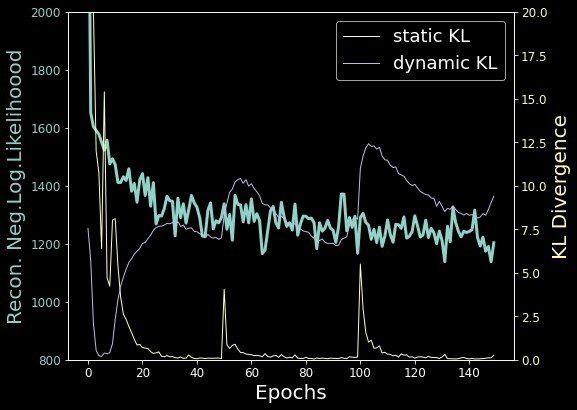

In [174]:
print(history.history.keys())
# print(plt.style.available)
# plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots()
ax1.plot(history.history['neg.log.like'], linewidth=3, color='C0', label='AE loss')
ax1.set_ylabel('Recon. Neg.Log.Likelihoood', color='C0')
ax1.set_ylim([800, 2000])
ax1.set_xlabel('Epochs')
ax1.tick_params(axis='y', labelcolor='C0')
ax2 = ax1.twinx()
ax2.plot(history.history['static KL'], color='C1', label='static KL')
ax2.plot(history.history['dynamic KL'], color='C2', label='dynamic KL')
ax2.set_ylabel('KL Divergence', color='C1')
ax2.set_ylim([0, 20])
ax2.tick_params(axis='y', labelcolor='C1')
ax2.legend(facecolor='k')

## Visualize Latents

* Visualize priors to confirm their locations were non-zero indicating they learned.
* Calculate 2-comp t-SNE on static latents
* Plot 1 trial: input (spike counts), static latents in t-SNE space, dynamic latents, generated factors, recon rates.
* Plot all trials, colour-coded by target: static latents in t-SNE space, dynamic latents as 2-D trajectories; plot per-target averages

In [175]:
# Create a colour code cycler e.g. 'C0', 'C1', etc.
# from itertools import cycle
# colour_codes = map('C{}'.format, cycle(range(10)))
# class_colors = np.array([next(colour_codes) for _ in range(10)])
class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
turbo_cmap = plt.cm.get_cmap('turbo')
c_categ = turbo_cmap(np.linspace(0, 1, 8))

In [176]:
# Collect data
t_vec = ax_info['timestamps']
feat_t_vec = t_vec[ae_model.readin.pooling//2::ae_model.readin.pooling]\
                if USE_READIN else t_vec
class_ids = np.zeros((0,), dtype=int)
static_latents = np.zeros((0, ae_model.static_encoder.latent_size))
dynamic_latents = np.zeros((0, len(feat_t_vec),
                            ae_model.dynamic_encoder.latent_size if DYNAMIC_GRAPH != 'none' else 1))
for batch in ds:
    class_ids = np.hstack((class_ids, np.argmax(batch[1].numpy(), axis=1)))
    p_full, features, q_f, q_z, facs, log_rates, p_full = ae_model(batch[0], return_intermediates=True)
    static_latents = np.vstack((static_latents, q_f.mean().numpy()))
    if DYNAMIC_GRAPH != 'none':
        dynamic_latents = np.vstack((dynamic_latents, q_z.mean().numpy()))
static_prior = ae_model.static_encoder.static_prior_factory().mean().numpy()
if DYNAMIC_GRAPH != 'none':
    dynamic_prior_samp, dynamic_prior_dist = ae_model.dynamic_encoder.sample_dynamic_prior(
        len(feat_t_vec), samples=1, batches=1)
    dynamic_prior = dynamic_prior_dist.mean().numpy().squeeze()

In [177]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


TEST_PERPLEXITY = 30  # 10, 30

# Precede TSNE with a PCA.
pca = PCA(n_components=static_latents.shape[-1])
static_latents_pca = pca.fit_transform(static_latents)

# Calculate t-SNE
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
static_latents_tsne = tsne_model.fit_transform(static_latents_pca)

In [178]:
# Find least squares solution relating static latents to tsne embedding.
#  Use this to identify best latent dims to plot
W = np.linalg.lstsq(np.hstack([static_latents, np.ones((len(static_latents), 1))]),
                    static_latents_tsne, rcond=None)[0]
b = W[-1, :]
W = W[:-1, :]
important_latent_dims = np.argsort(np.sum(np.abs(W), axis=1))[::-1]

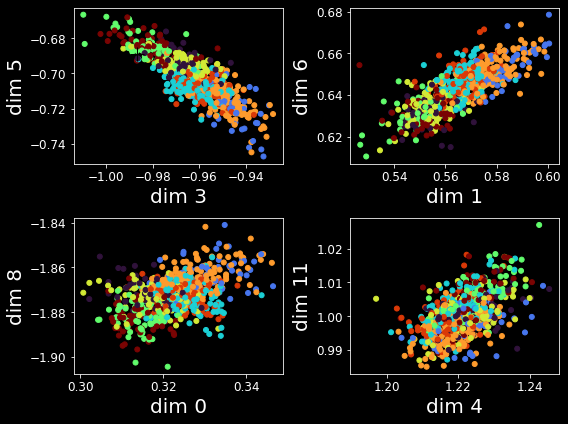

In [179]:
# Scatter plot per class
plot_range = [-5.0, 5.0]
# print(plt.style.available)
plt.style.use('dark_background')
fig = plt.figure(figsize=[8, 6], tight_layout=True)
axes = fig.subplots(2, 2)

for pair_ix, dim_pair in enumerate(important_latent_dims[:8].reshape((4, 2))):
    row_ix = pair_ix // 2
    col_ix = pair_ix % 2
    dat = static_latents[:, dim_pair]
    plot_lim = int(np.ceil(np.max(np.abs(dat))))
    axes[row_ix, col_ix].scatter(dat[:, 0], dat[:, 1],
                                 c=c_categ[class_ids])
    axes[row_ix, col_ix].scatter(static_prior[dim_pair[0]], static_prior[dim_pair[1]],
                                 s=200, c='k', marker='+')
#     axes[row_ix, col_ix].set_xlim([-plot_lim, plot_lim])
#     axes[row_ix, col_ix].set_ylim([-plot_lim, plot_lim])
    axes[row_ix, col_ix].set_xlabel(f"dim {dim_pair[0]}")
    axes[row_ix, col_ix].set_ylabel(f"dim {dim_pair[1]}")
#     axes[row_ix, col_ix].set_xticks([-plot_lim, 0, plot_lim])
#     axes[row_ix, col_ix].set_yticks([-plot_lim, 0, plot_lim])
    

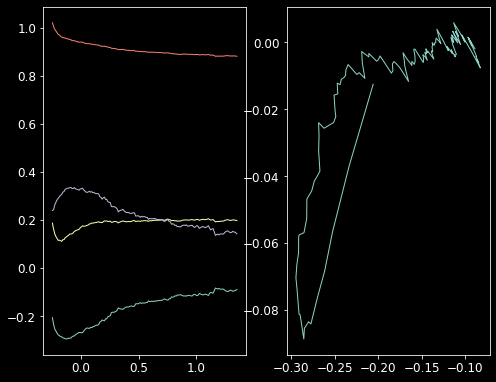

In [180]:
if DYNAMIC_GRAPH != 'none':
    plt.subplot(1, 2, 1)
    plt.plot(feat_t_vec, dynamic_prior + 0.2*np.arange(dynamic_prior.shape[-1]).reshape((1, -1)))
    plt.subplot(1, 2, 2)
    plt.plot(dynamic_prior[:, 0], dynamic_prior[:, 1])

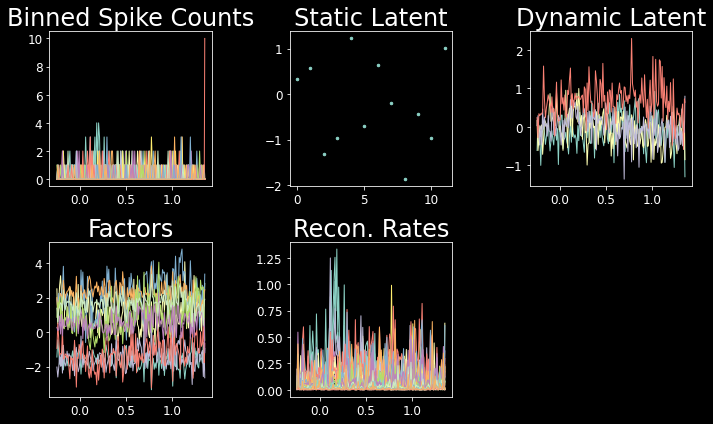

In [181]:
# batch (inputs) p_full, features, q_f, q_z, facs, log_rates, p_full
tr_ix = 1  # in batch

fig = plt.figure(figsize=[10, 6], tight_layout=True)

plt.subplot(2, 3, 1)
plt.plot(t_vec, batch[0][tr_ix])
plt.title('Binned Spike Counts')
#plt.ylim([0, 6])

plt.subplot(2, 3, 2)
# TODO: better way to represent per-trial static latent? t-sne space?
plt.plot(q_f.mean()[tr_ix], '.')
plt.title('Static Latent')

if DYNAMIC_GRAPH != 'none':
    plt.subplot(2, 3, 3)
    plt.plot(feat_t_vec, q_z.mean()[tr_ix])
    plt.title('Dynamic Latent')

plt.subplot(2, 3, 4)
plt.plot(feat_t_vec, facs[tr_ix])
plt.title('Factors')

plt.subplot(2, 3, 5)
plt.plot(t_vec, p_full.mean()[tr_ix])
plt.title('Recon. Rates')
#plt.ylim([0, 6])
plt.tight_layout()
plt.show()

In [168]:
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], c=c_categ[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title + ' (Ppx: {})'.format(perplexity))
    ax = plt.gca()

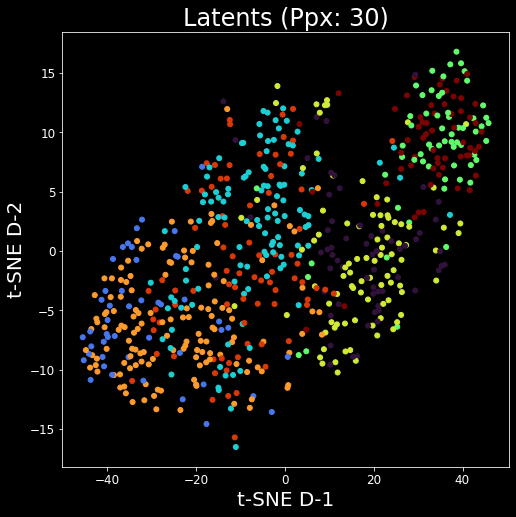

In [182]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plot_tsne(static_latents_tsne, class_ids, TEST_PERPLEXITY, title='Latents')

In [183]:
from sklearn.linear_model import LogisticRegressionCV

clf = make_pipeline(StandardScaler(), LogisticRegressionCV(cv=5, random_state=0, 
                                                           max_iter=4000))
clf.fit(static_latents, class_ids)
print(clf.score(static_latents, class_ids))

0.6341463414634146


In [184]:
X_rates, Y_class, _ = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates',
                                        **{**load_kwargs, 'resample_X': 1})
X_rates = X_rates.reshape(X_rates.shape[0], -1)
Y_class = Y_class.ravel()
clf.fit(X_rates, Y_class)
print(clf.score(X_rates, Y_class))

Found 663 trials, 161 timestamps(-0.25 to 1.35 at 100.0 Hz), 36 channels
Returning Y as sacClass with shape (663, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
0.9939668174962293
